# Big picture

Before we dive into data exploration we wanted to understand the setting from which the data was taken. 

The data is taken from Kaggle: https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction.

We are tasked with predicting the status of patients with Cirrhosis. From Kaggle 'Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption.' The data spans 1974 to 1984 at the Mayo Clinic study located in Rochester, Minnesota, United States. 

The status was measured after N days, and there are three possibilities:

* D - the patient died
* C - censored - meaning the patient is still alive
* CL - censored due to liver transplantation - meaning the patient had a liver transplant and is still alive

Making these predictions could give patients an idea of their chance of living or help make automated decisions on which patients get a liver transplant.

# Data Exploration

We perform data exploration to understand properties, importance and relationships of the variables in our dataset.

## Load Libraries

First we load the packages that we will use.

In [87]:
import sys
#!{sys.executable} -m pip install numpy pandas matplotlib seaborn scikit-learn | grep -v 'already satisfied'
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, make_scorer, f1_score, log_loss, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, learning_curve
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
from xgboost import plot_importance
import missforest.missforest as mf
from sklearn.impute import SimpleImputer, KNNImputer
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from missforest.missforest import MissForest
import miceforest as mf
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier



## Read in the data

In [3]:
# On lab machines
# train = pd.read_csv("/cs/studres/ID5059/Coursework/Coursework-2/data/train.csv", index_col=False)

train = pd.read_csv("train.csv", index_col=False)

In [4]:
# Look at data structure
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [5]:
# Get all the columns names
train.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')

## Correcting the Data Types

From Kaggle: https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction, we see that the data types should be:
* ID: Integer
* N_Days: Integer
* Status: Categorical
* Drug: Categorical
* Age: Integer
* Sex: Categorical
* Ascites: Categorical
* Hepatomegaly: Categorical
* Spiders: Categorical
* Edema: Categorical
* Bilirubin: Continuous
* Cholesterol: Integer
* Albumin: Continuous
* Copper: Integer
* Alk_Phos: Continuous
* SGOT: Continuous
* Tryglicerides: Integer
* Platelets: Integer
* Prothrombin: Continuous
* Stage: Categorical

Now we look at what they are on reading in the data:

In [6]:
# Data Types on reading in the data
train.dtypes

id                 int64
N_Days             int64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
dtype: object

From this we need to make the following conversions:
* Drug object -> Categorical
* Sex object -> Categorical
* Ascites object -> Categorical
* Hepatomegaly object -> Categorical
* Spiders object -> Categorical
* Edema object -> Categorical
* Cholesterol object -> Integer
* Copper float64 -> Integer
* Tryglicerides float64 -> Integer
* Platelets float64 -> Integer
* Stage float64 -> Integer
* Status object -> Categorical

We now make the conversions:

In [7]:
# Columns that should be Categorical
columns_to_convert_cat = ['Drug','Sex', 'Ascites', 'Hepatomegaly', 'Spiders','Edema', 'Status']

# Convert
train[columns_to_convert_cat] = train[columns_to_convert_cat].astype('category')

# Columns that should be Integer
columns_to_convert_int = ['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets','Stage']

# Convert
train[columns_to_convert_int] = train[columns_to_convert_int].astype('int64')

In [8]:
# Double check for missing data
na_rows = train.isna().sum(axis=0)
na_rows

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

We also check for unique idenitifiers and find that the only one is id.

In [9]:
# Checking for unique idenitifiers
train.nunique() == train.shape[0]

id                True
N_Days           False
Drug             False
Age              False
Sex              False
Ascites          False
Hepatomegaly     False
Spiders          False
Edema            False
Bilirubin        False
Cholesterol      False
Albumin          False
Copper           False
Alk_Phos         False
SGOT             False
Tryglicerides    False
Platelets        False
Prothrombin      False
Stage            False
Status           False
dtype: bool

## Inspecting Status

Status is what we want to predict. Recall that Status can take the following three options:
* D (death)
* C (censored)
* CL (censored due to liver transplantation)

We wanted to check for class imbalance in Status, which can impact choice of modelling methods. We made a pie chart (below) and found that the classes were very unbalanced with censored being the majority of cases (62.8%), died the second most (33.7%) and censored with a liver transplant a tiny fraction (3.5%).

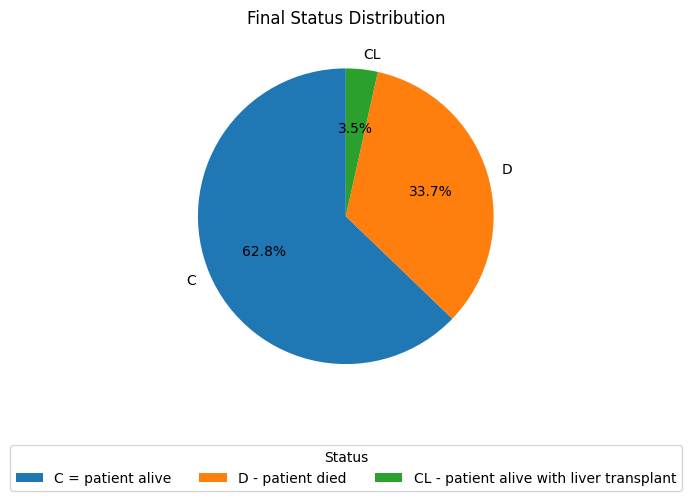

In [10]:
# Making a pie chart for Status categories
status_counts = train['Status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Final Status Distribution')
custom_labels = ['C = patient alive', 'D - patient died', 'CL - patient alive with liver transplant']
plt.legend(custom_labels, title="Status", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

## Distributions of predictor variables

### Continous Variables

For many modelling methods, continuous variables ideally should have a distribution close to normal. If the distribution is skewed, then a log transform makes sense. We plotted histograms of our continuous variables below, and given these plots we would log transform the following variables if included in the model: Bilirubin, Cholesterol, Copper, Alk_Phos, SGOT, Tryglicerides and Prothrombin.

Stage is discrete so we are not worried about it following a normal distribution, and we show separate analysis of this variable later.

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'N_Days'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Bilirubin'}>],
       [<Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'Albumin'}>,
        <Axes: title={'center': 'Copper'}>,
        <Axes: title={'center': 'Alk_Phos'}>],
       [<Axes: title={'center': 'SGOT'}>,
        <Axes: title={'center': 'Tryglicerides'}>,
        <Axes: title={'center': 'Platelets'}>,
        <Axes: title={'center': 'Prothrombin'}>],
       [<Axes: title={'center': 'Stage'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

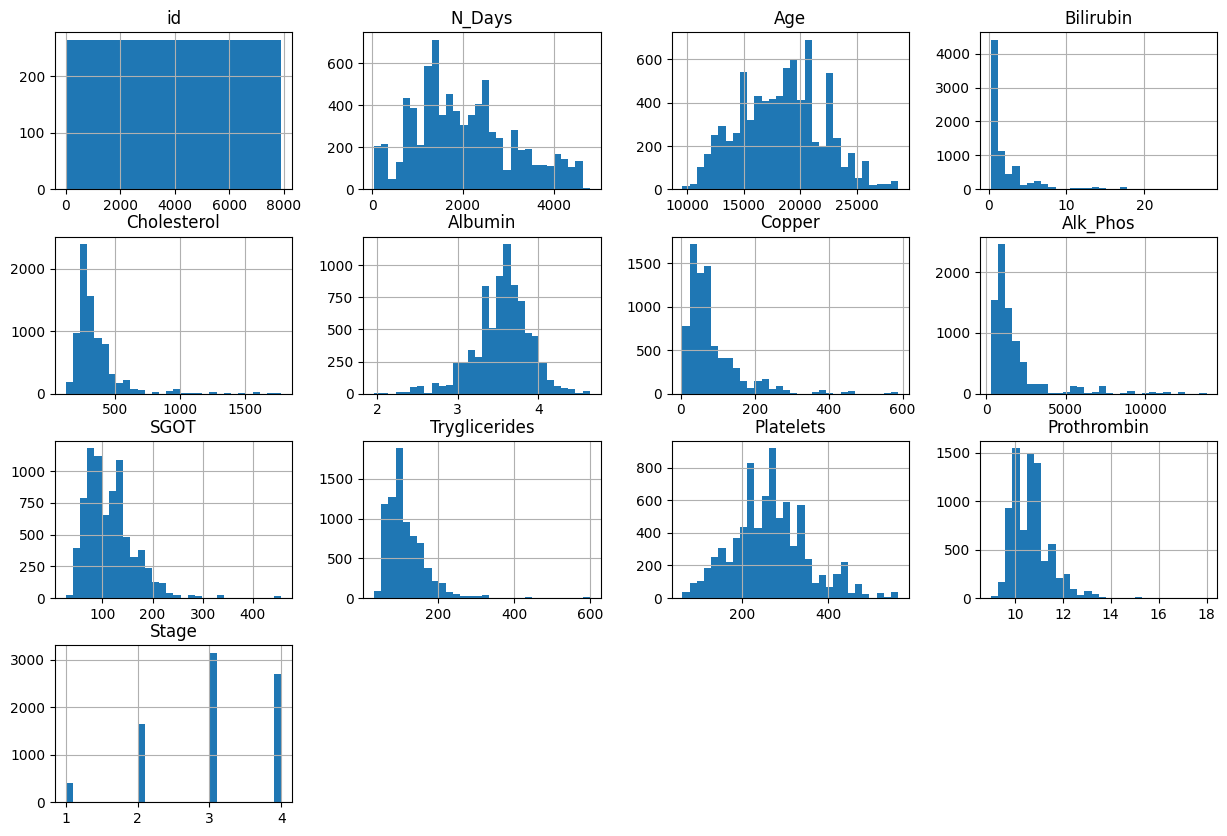

In [11]:
# Filter numeric columns
numeric_columns = train.select_dtypes(include='number').columns
# Plot histograms
train.hist(bins = 30, figsize=(15, 10))

### Categorical variables

We look at which categorical variables are imbalanced through pie charts. We find that Sex, Ascites, Spiders (less so than the others), and Edema are unbalanced. 

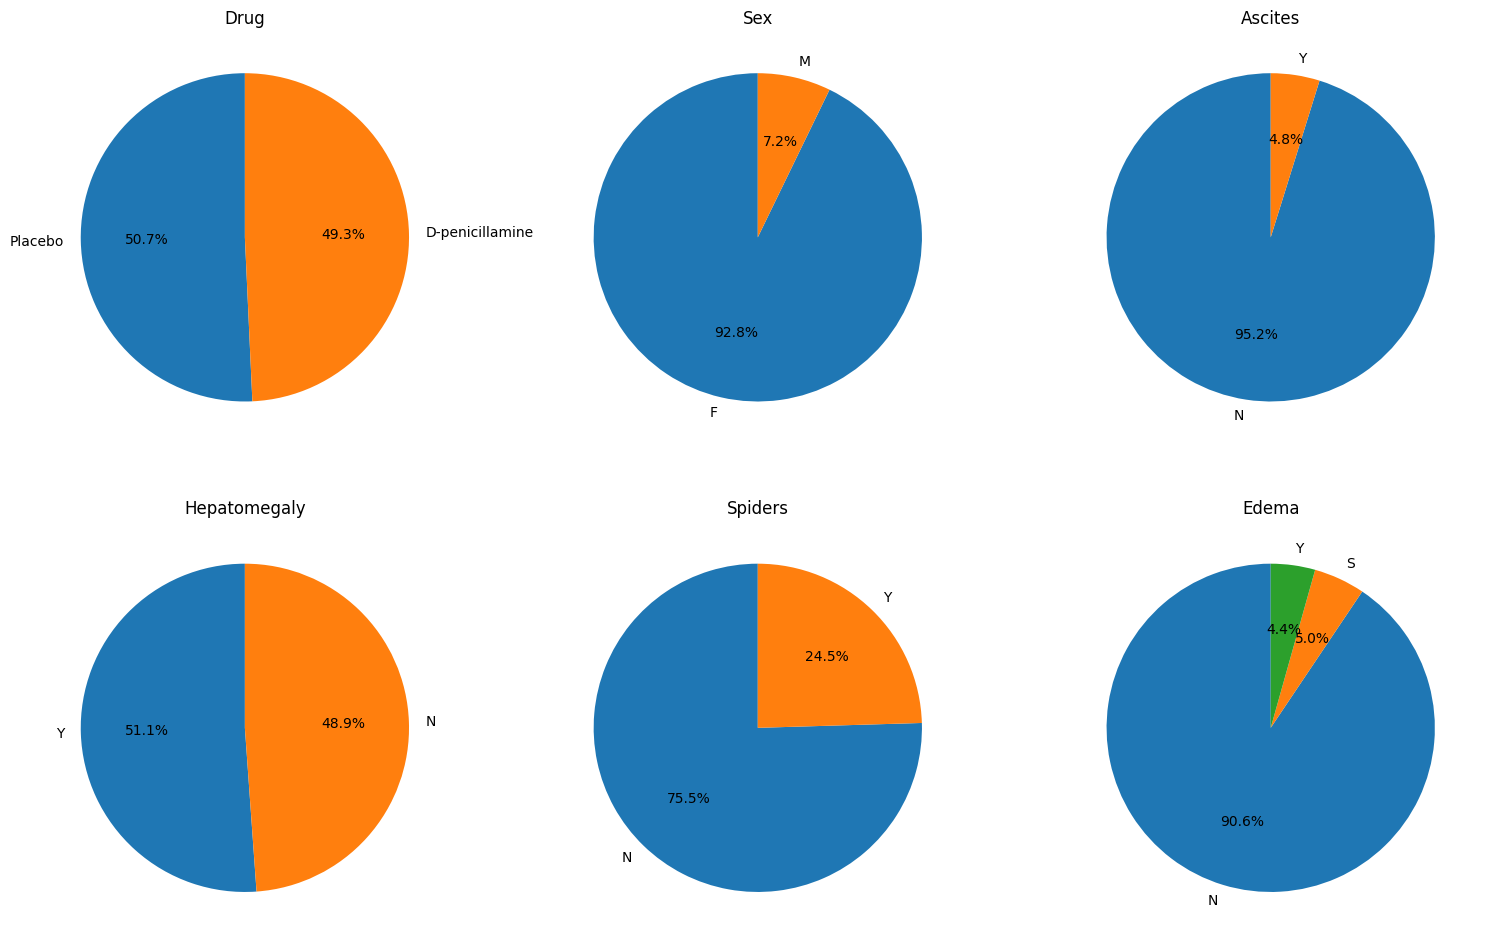

In [12]:
# Filter non-numeric columns
non_numeric_columns = train.select_dtypes(include='category').columns

# Create a grid of pie charts
fig, axes = plt.subplots(nrows=len(non_numeric_columns) // 3 , ncols=3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over non-numeric columns and plot pie charts
for i, column in enumerate(non_numeric_columns.drop('Status')):   
    v_counts = train[column].value_counts()
    axes[i].pie(v_counts, labels=v_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(column)
    

# Adjust layout
plt.tight_layout()
plt.show()

As we mentioned above stage is discrete and is truly ordered categorical, and we should look at category imbalance here as well. There are relatively few in 1st stage of the disease. 

Text(0.5, 1.0, 'Stage')

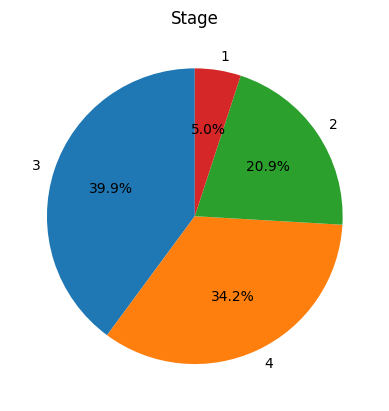

In [13]:
v_counts = train['Stage'].value_counts()
plt.pie(v_counts, labels=v_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Stage')

## Order

We need to check whether the data is in a random order or not. The data seeems to be random apart from id. We will shuffle the data during the data modelling just to be safe.

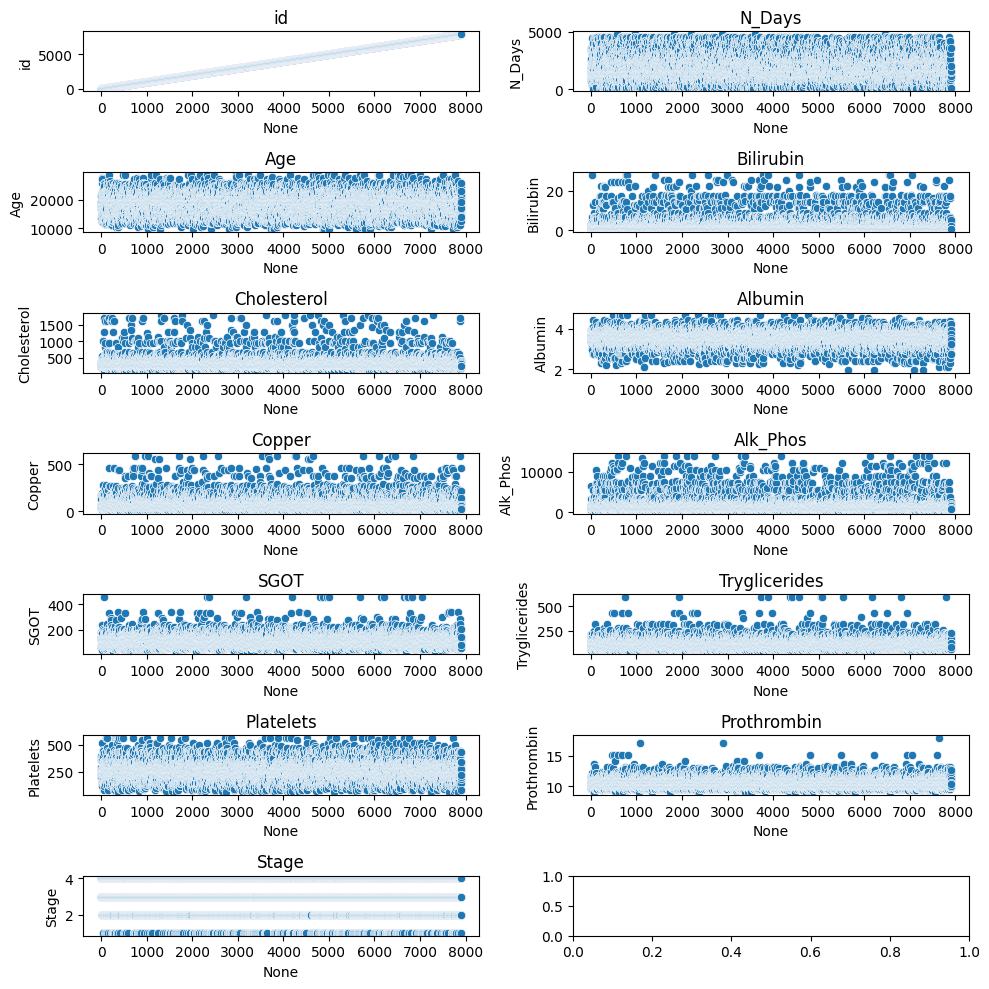

In [14]:
# Numeric columns
fig, axes = plt.subplots(nrows=len(numeric_columns) // 2 + 1, ncols=2, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over numeric columns and plot scatter plot
for i, column in enumerate(numeric_columns):
    sns.scatterplot(x=train.index, y=train[column],ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()

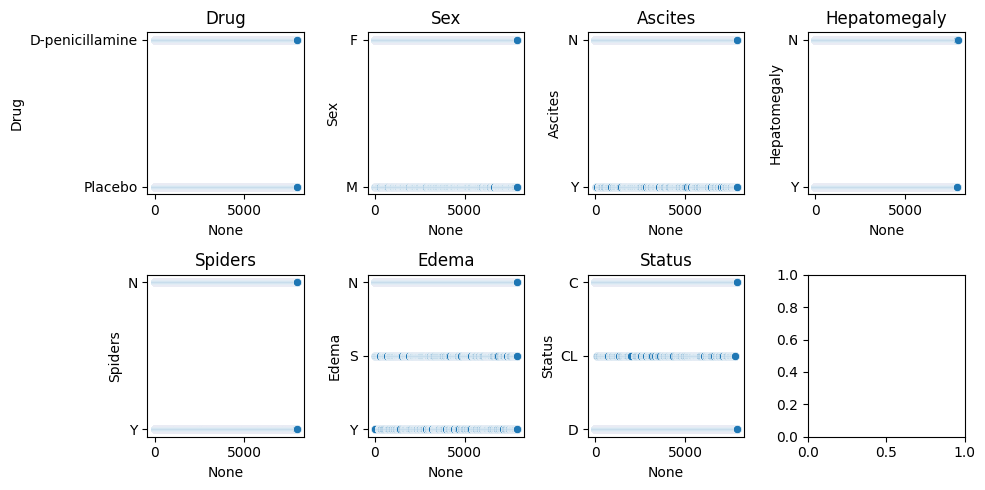

In [15]:
# Non-numeric columns
fig, axes = plt.subplots(nrows=len(non_numeric_columns) // 4 + 1 , ncols=4, figsize=(10, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over numeric columns and plot scatter plot
for i, column in enumerate(non_numeric_columns):
    sns.scatterplot(x=train.index, y=train[column],ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()

## Status vs predictors

We now look at the relationships between Status and the predictors to gauge importance of variables and so which to keep.

### Status vs continous predictors

For each predictor we make a box plot per status and see how the distributions vary with predictor. If the box plots overlap a lot, the predictor is not providing much information to differentiate between the classes. So ideally we want boxplots that look quite different across the classes. we paid special attention to if any variable made it easier to differentiate CL from the other classes as it is such as small class and may be hard to predict.

From this we decide that Alk_Phos, Cholesterol, Albumin and Triglycerides and id do not seem that important. id is a unique idenitifier so we will remove that anyway.

While age looked like a significant factor in differentiating between CL and the other classes.

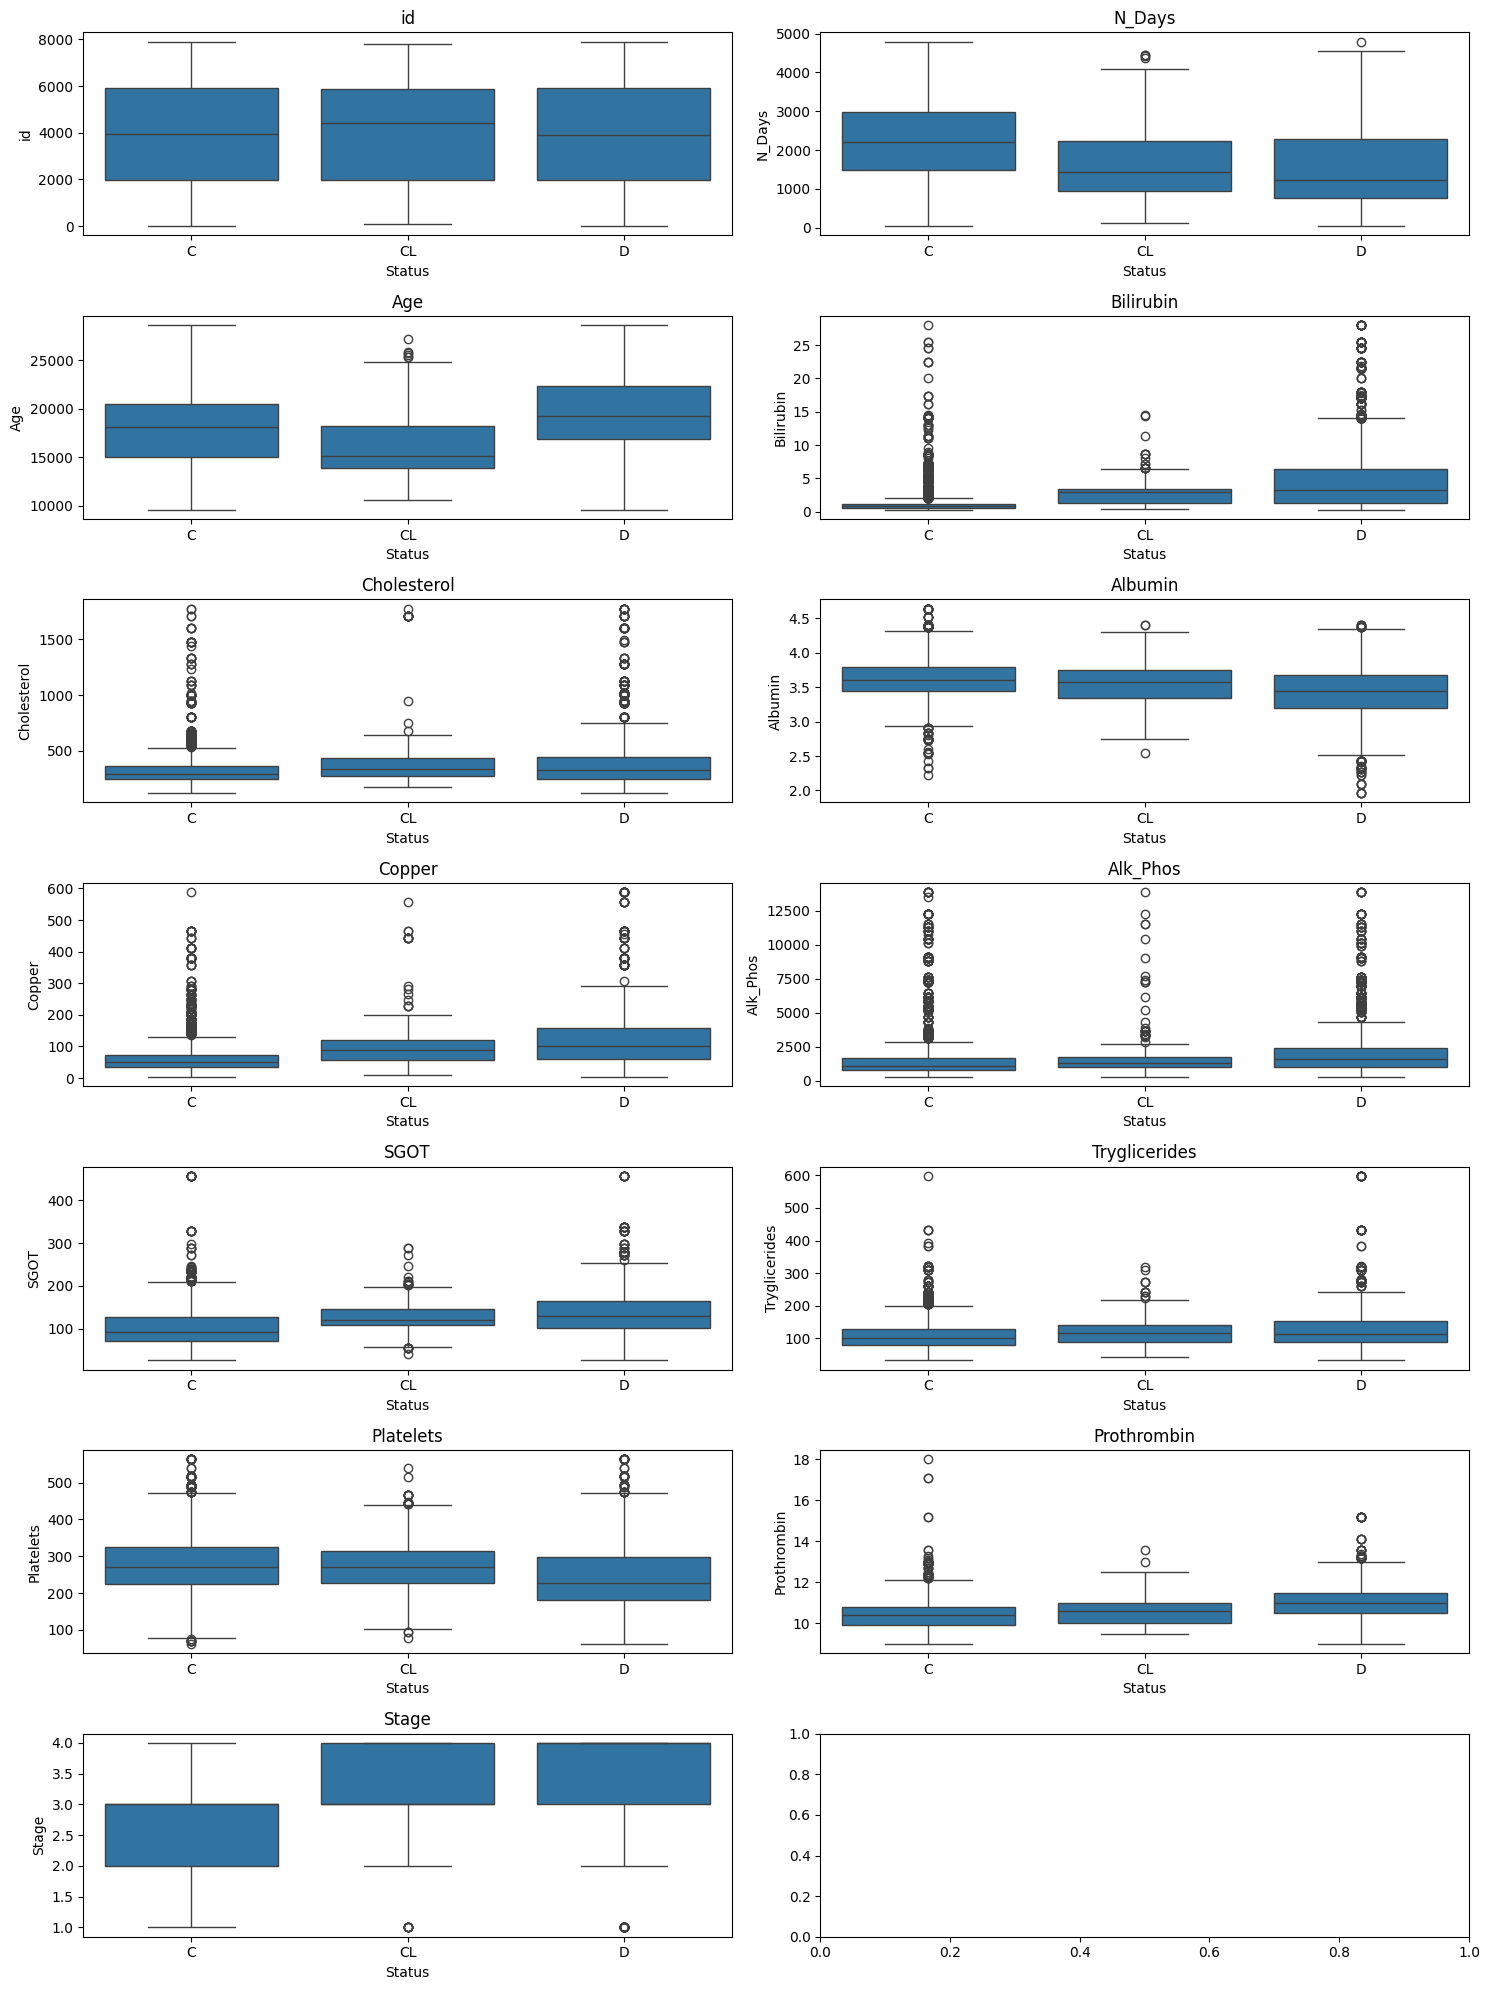

In [16]:
# Create a grid of graphs
fig, axes = plt.subplots(nrows=len(numeric_columns) // 2 + 1, ncols=2, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over numeric columns and plot box plots
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=train['Status'], y=train[column],ax=axes[i]) 
    axes[i].set_title(column)
    

# Adjust layout
plt.tight_layout()
plt.show()

### Status vs categorical predictors

To look at the relationships between status and categorical predictions we use cross tabulation tables as a heat maps. The rows of each plot represent the different predictor categories. The idea is that if the categories contain significant information for prediction then the two or three rows should show different patterns. If the rows show similar colouring, then the predictor is not very helpful. Note that we have scaled each row by its total; otherwise imbalanced categories would cause different colouration no matter what. From this analysis it looks like Drug is not a great predictor.

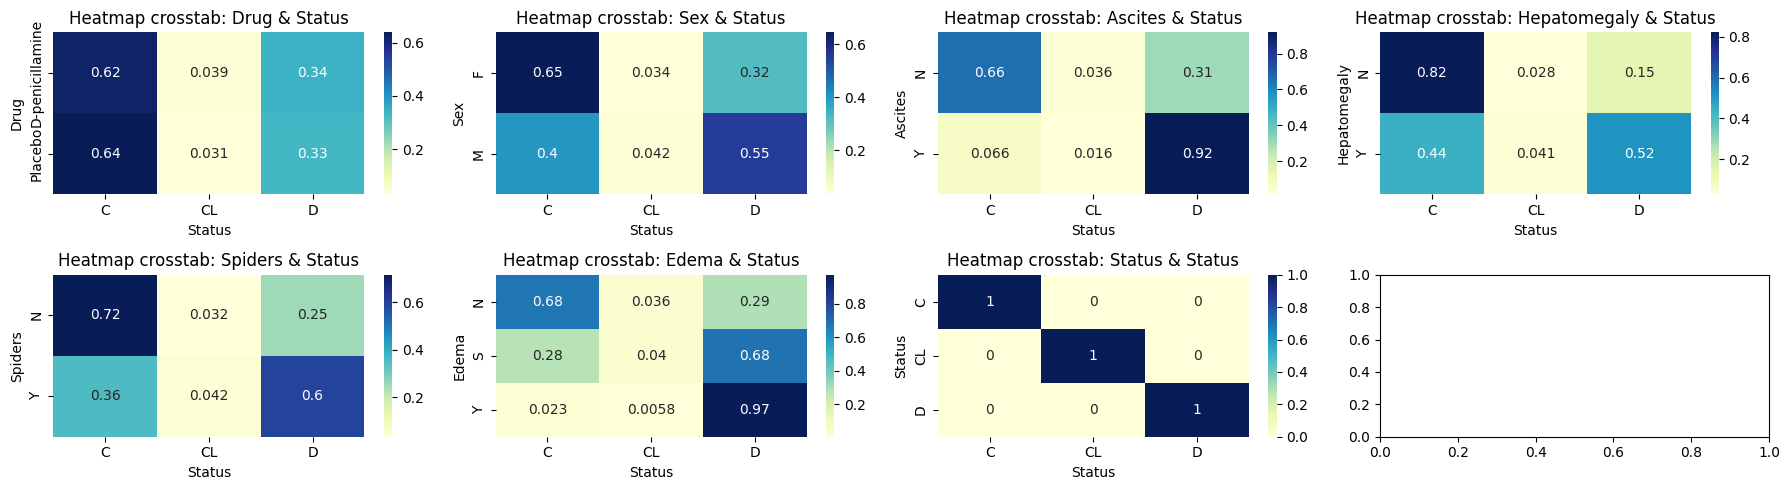

In [17]:
non_numeric_columns = train.select_dtypes(include='category').columns
# Create a grid of cross-tabulations as a heatmap just for Status with all the other categorical variables
plots_created = 0
plots_per_row = 4
fig, axes = plt.subplots(nrows=2, ncols=plots_per_row, figsize=(18, 5))

for i in range(len(non_numeric_columns)):
        col1 = non_numeric_columns[i]
        crosstab = pd.crosstab(train[col1], train['Status'])
        
        # Making it proportions
        row_totals = crosstab.sum(axis=1)

        # Divide each element by its corresponding row total
        crosstab = crosstab.div(row_totals, axis=0)

        # Create a heatmap
        sns.heatmap(crosstab, annot=True, cmap="YlGnBu", ax=axes[plots_created // plots_per_row, plots_created % plots_per_row])  # 'd' for integer formatting
        axes[plots_created // plots_per_row, plots_created % plots_per_row].set_title(f"Heatmap crosstab: {col1} & {'Status'}")
        axes[plots_created // plots_per_row, plots_created % plots_per_row].set_xlabel('Status')
        axes[plots_created // plots_per_row, plots_created % plots_per_row].set_ylabel(col1)
        
        plots_created += 1

# Adjust layout
plt.tight_layout()
plt.show()

Another way of representing this information is using a stacked bar plot that scales the data. If the bars look similar then the predictor is poor. We again look to see if any variable is particularly useful for showing patterns in CL.

Overall each predictor seems to show a significant effect on the Status apart from Drug. 

We actually discovered through this anlysis that Hepatomegaly and Spiders follow similar patterns and look like they could be related. We researched to see if they were related and found that Spider and also Ascites are symtoms of Hepatomegaly; source: https://patient.info/doctor/hepatomegaly#:~:text=There%20may%20be%20hepatomegaly%20symptoms,xanthelasma%20suggests%20autoimmune%20liver%20disease. So we probably only want to keep the most important one.

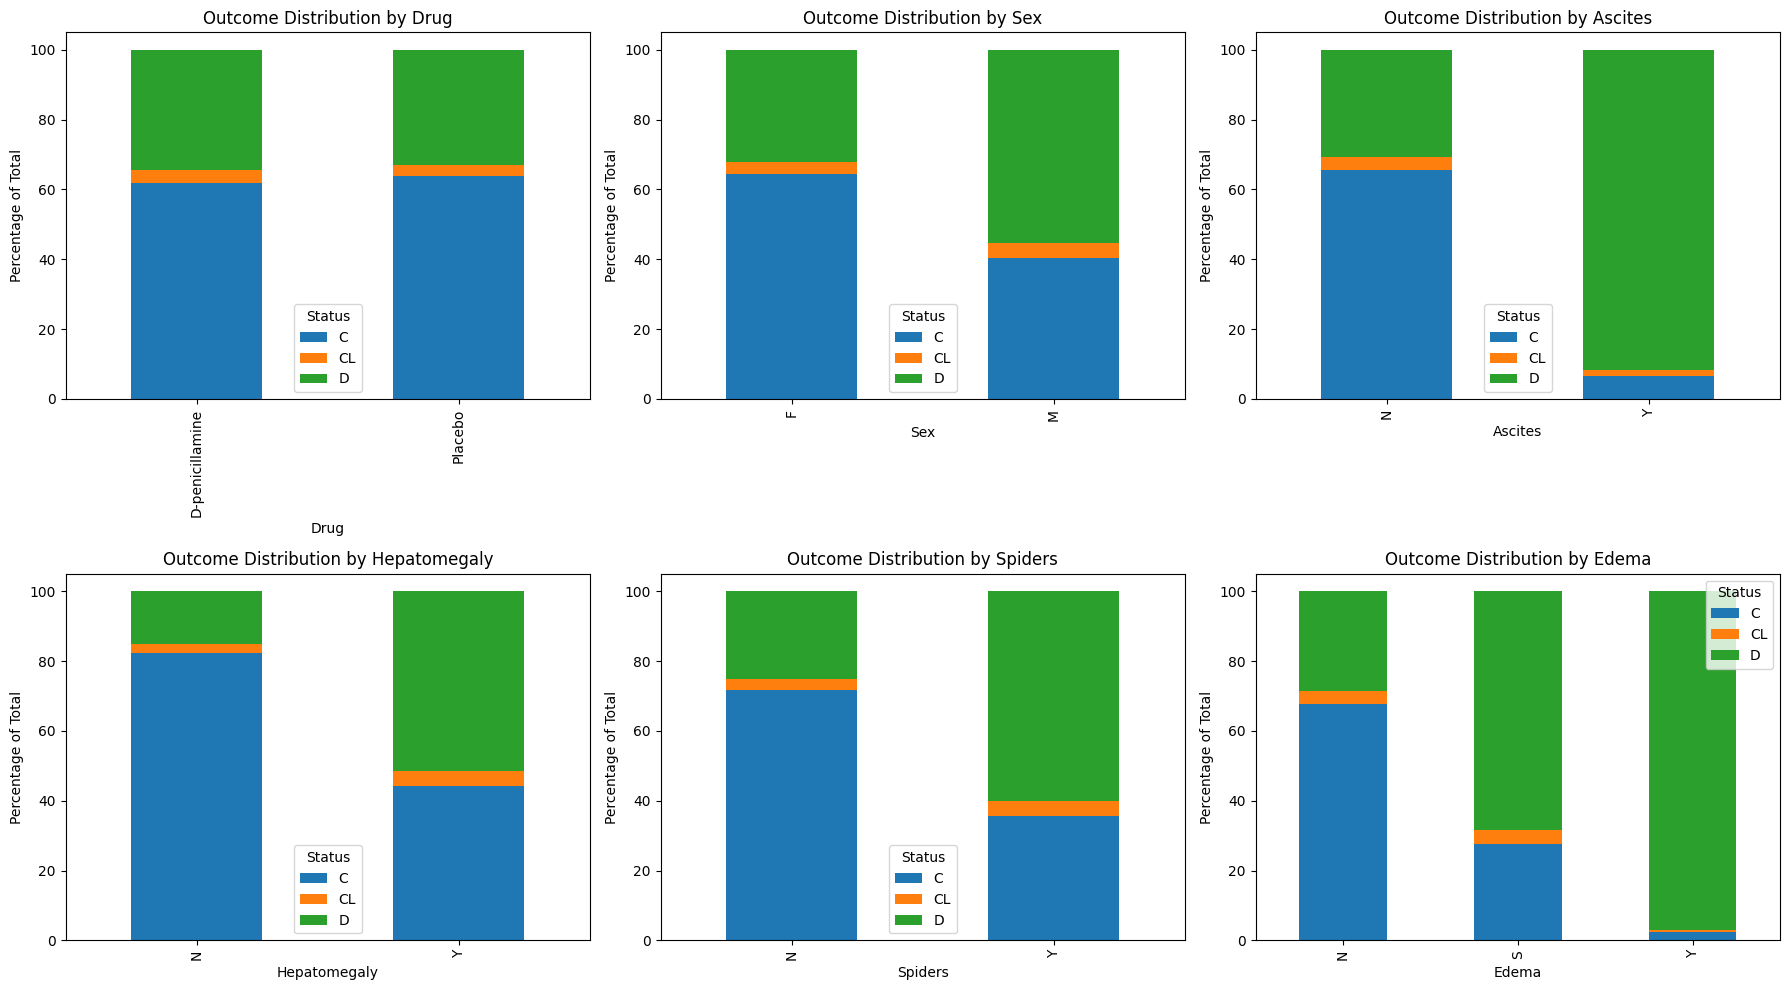

In [18]:
# Making a stacked bar chart of all categories split up by category and then Status
non_numeric_columns = train.select_dtypes(include='category').columns
plots_created = 0
plots_per_row = 4
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten axes
axes = axes.flatten()

for i, column in enumerate(non_numeric_columns.drop('Status')):
    status_counts = train.groupby(column,observed=False)['Status'].value_counts(normalize=True).unstack() * 100
    status_counts.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title('Outcome Distribution by '+ column)
    axes[i].set_ylabel('Percentage of Total')  # Corrected ylabel

# Adjust layout
plt.tight_layout()
plt.show()

To choose between the three variables Spider, Ascites and Hepatomegaly we used Chi-squared tests of independence on them against Status. The null hypothesis is that they are independent. All three variables rejected the null hypothesis, but Hepatomegaly had the most significant p-value so we decided to keep this variable out of the three (see after the cross tabulations). However, one of the coniditons to use the Chi-squared test is that there are enough observations in each cell, with a rule of thumb being at least 5 observations. We checked this using unscaled cross tabulation tables for Status against Spider, Ascites and Hepatomegaly (below).

In [19]:
competing_cats = ['Spiders', 'Ascites', 'Hepatomegaly']

for col1 in competing_cats:
    crosstab = pd.crosstab(train[col1], train['Status'])
    print(f"Cross-tabulation for {col1} vs Status:")
    print(crosstab)
    print("\n")

Cross-tabulation for Spiders vs Status:
Status      C   CL     D
Spiders                 
N        4272  193  1501
Y         693   82  1164


Cross-tabulation for Ascites vs Status:
Status      C   CL     D
Ascites                 
N        4940  269  2316
Y          25    6   349


Cross-tabulation for Hepatomegaly vs Status:
Status           C   CL     D
Hepatomegaly                 
N             3174  109   580
Y             1791  166  2085




The Chi-squared tests:

In [20]:
competing_cats = ['Spiders', 'Ascites', 'Hepatomegaly']

# List to store results
results = []
# Iterate over each categorical variable
for column in competing_cats:  # Exclude the response variable
    contingency_table = pd.crosstab(train[column], train['Status'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # Append results to the list
    results.append({'Variable': column,
                    'Chi-squared statistic': chi2,
                    'P-value': p,
                    'Degrees of freedom': dof})
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame by the p-value column
results_df_sorted = results_df.sort_values(by='P-value')

print("Results DataFrame (Sorted by P-value):")
results_df_sorted

Results DataFrame (Sorted by P-value):


,Variable,Chi-squared statistic,P-value,Degrees of freedom
2,Hepatomegaly,1243.548926,9.263641e-271,2
0,Spiders,831.715175,2.485104e-181,2
1,Ascites,605.196440,3.830565e-132,2


## Correlations

For the continuous variables we use a correlation matrix to see if variables are linearly related. We found the most correlated continous variables are Bilirubin and Copper but these are only weakly correlated at 60%.

<Axes: >

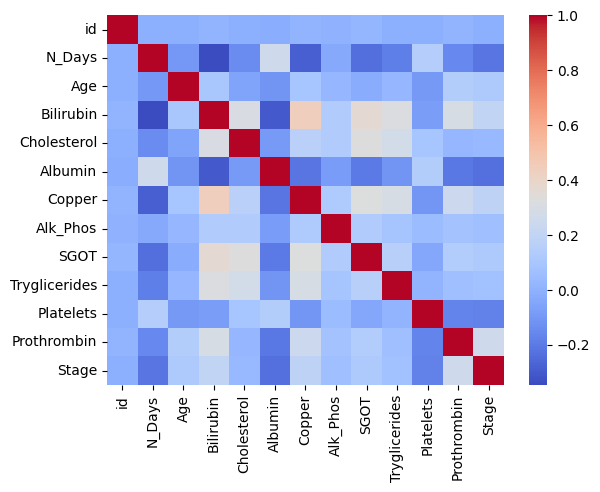

In [21]:
#correlations
correlations = train.corr(numeric_only=True)
correlations
sns.heatmap(correlations, annot=False, cmap='coolwarm')

For the categorical variables we have already have seen that Ascites, Spiders and Hepatomegaly are related. We look at the cross tab plots for all the categorical variables to see if we can find any further relationships. However we don't find any further relationships from this.

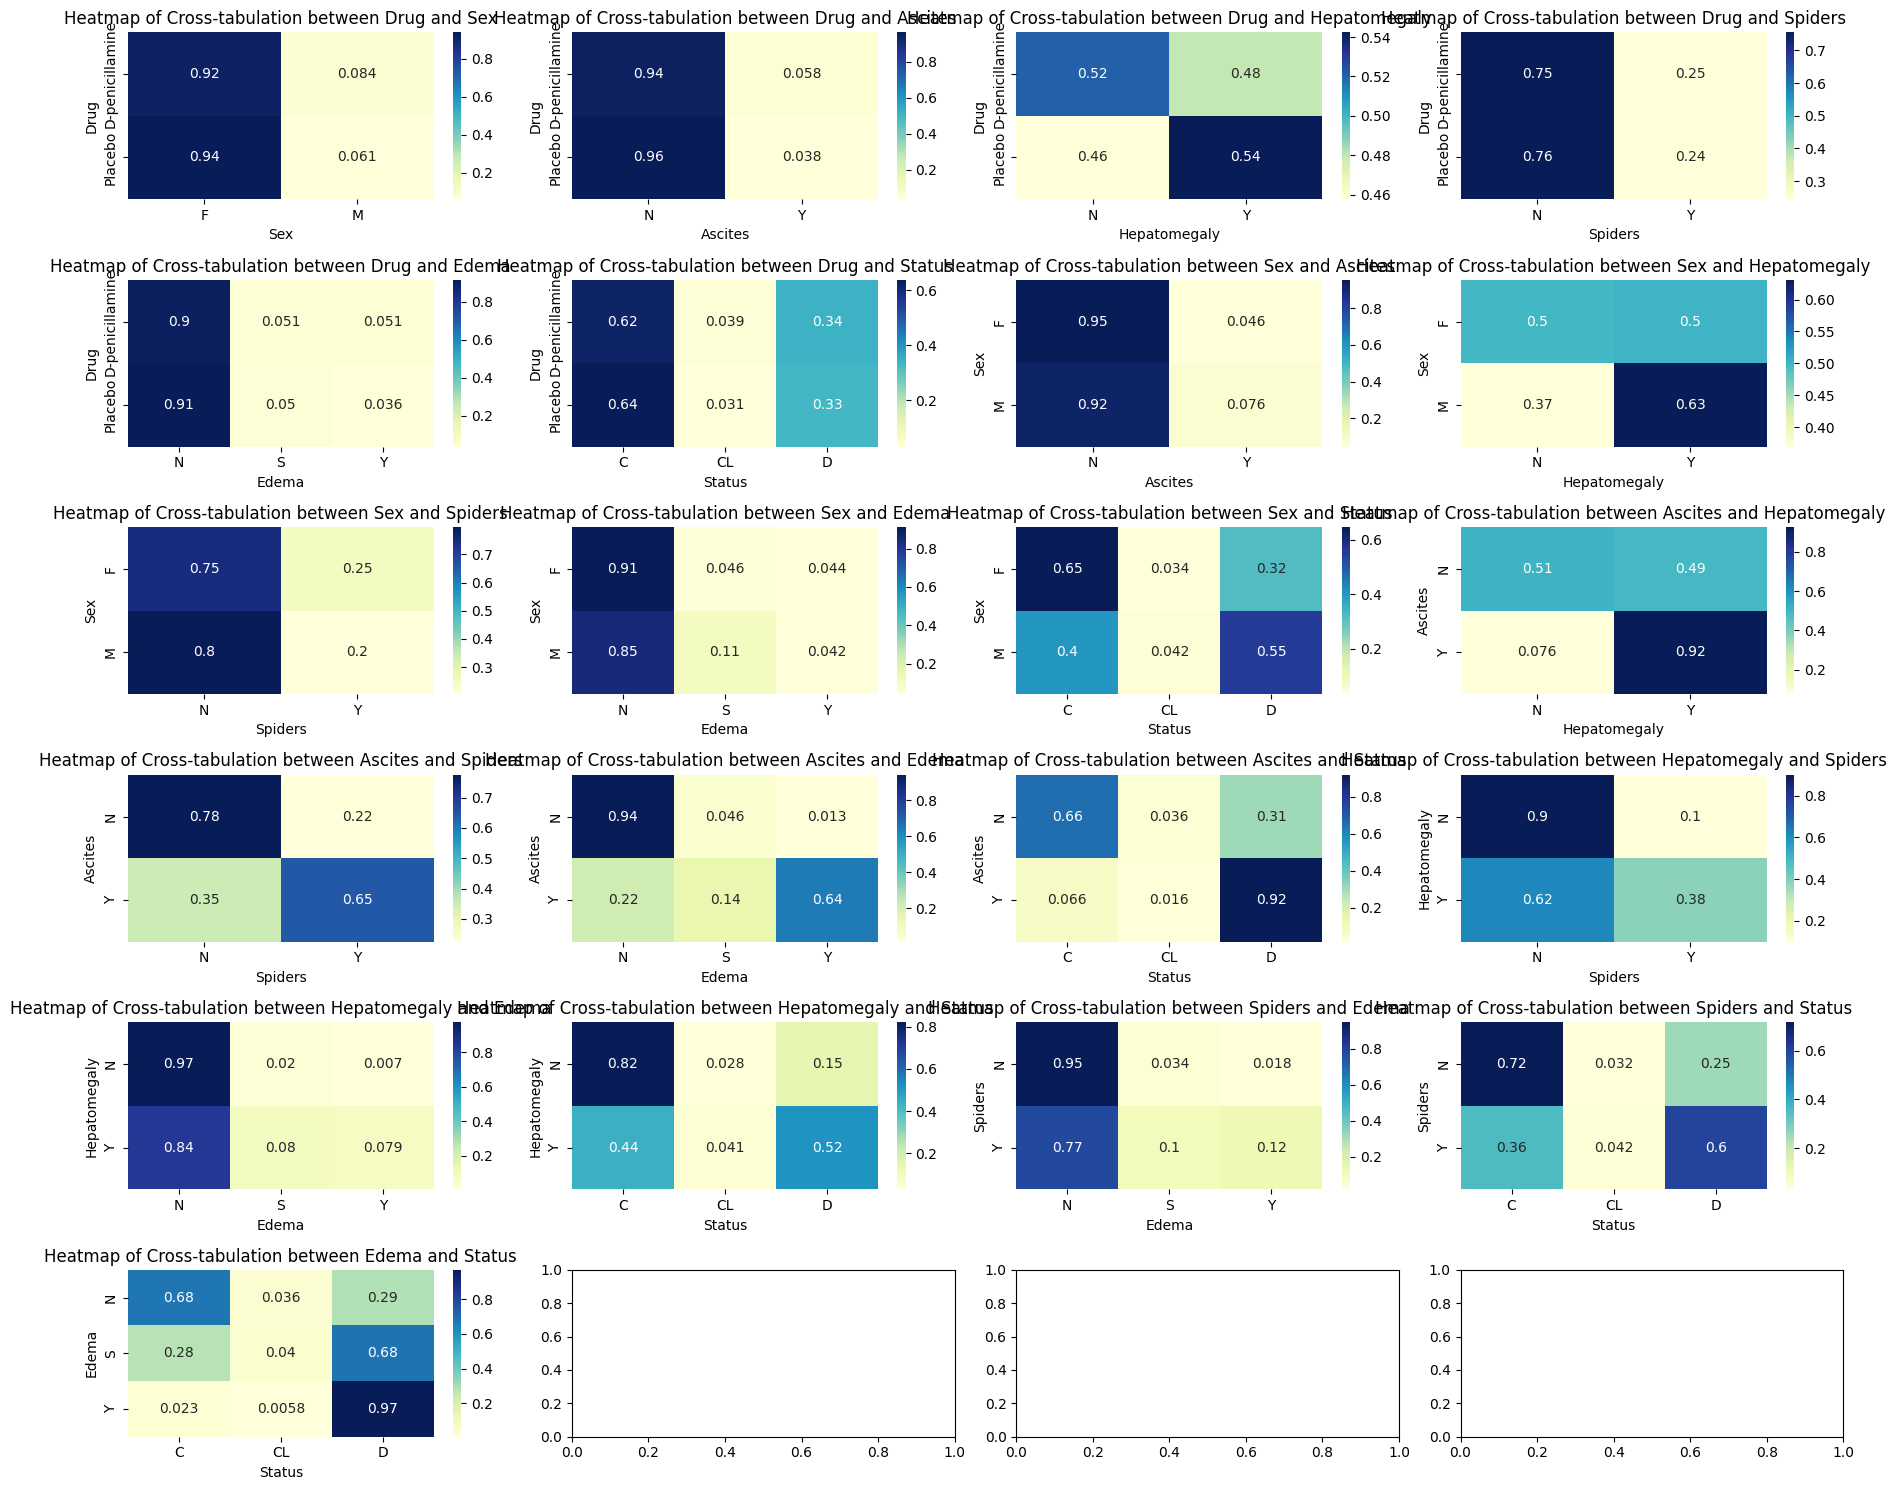

In [22]:
# Create a grid of cross-tabulations as a heatmap
plots_created = 0
plots_per_row = 4
fig, axes = plt.subplots(nrows=6, ncols=plots_per_row, figsize=(18, 15))

for i in range(len(non_numeric_columns)):
    for j in range(i + 1, len(non_numeric_columns)):  # Start from i+1 to avoid duplicates
        col1 = non_numeric_columns[i]
        col2 = non_numeric_columns[j]
        crosstab = pd.crosstab(train[col1], train[col2])
        
        # Making it proportions
        row_totals = crosstab.sum(axis=1)

        # Divide each element by its corresponding row total
        crosstab = crosstab.div(row_totals, axis=0)

        
        # Create a heatmap
        sns.heatmap(crosstab, annot=True, cmap="YlGnBu", ax=axes[plots_created // plots_per_row, plots_created % plots_per_row])  # 'd' for integer formatting
        axes[plots_created // plots_per_row, plots_created % plots_per_row].set_title(f"Heatmap of Cross-tabulation between {col1} and {col2}")
        axes[plots_created // plots_per_row, plots_created % plots_per_row].set_xlabel(col2)
        axes[plots_created // plots_per_row, plots_created % plots_per_row].set_ylabel(col1)
        
        plots_created += 1

# Adjust layout
plt.tight_layout()
plt.show()

## Elastic net as exploratory analysis

Elastic net can be used an exploratory method, as it shrinks variables it deems unimportant to 0. We must bear in mind that elastic net is a regression based model, so these results may not be directly transferrable to all models but is worth looking at.

In [23]:
# We save the orginal numeric columns before converting to binary, as we will need later
orig_numerical_attributes = train.select_dtypes(include='number').columns

Usually, one hot encoding is used to convert categories into a numeric form. It involves making extra binary columns: 1 if the instance falls into that category and 0 otehrwise. This is bad for regression models, as these extra columns will be correlated. So instead we made categories with only two variables binary for the purpose of elastic net.

In [24]:
# Loop through each column
for col in train.columns:
    # Check if the number of unique values in the column is 2
    if len(train[col].unique()) == 2:
        # Convert the column to binary (1, 0)
        train[col] = (train[col] == train[col].unique()[0]).astype(int)

In [25]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,1,21532,1,1,1,1,N,2.3,316,3.35,172,1601.0,179.80,63,394,9.7,3,D
1,1,2574,0,19237,0,1,1,1,N,0.9,364,3.54,63,1440.0,134.85,88,361,11.0,3,C
2,2,3428,0,13727,0,1,0,0,Y,3.3,299,3.55,131,1029.0,119.35,50,199,11.7,4,D
3,3,2576,0,18460,0,1,1,1,N,0.6,256,3.50,58,1653.0,71.30,96,269,10.7,3,C
4,4,788,0,16658,0,1,0,1,N,1.1,346,3.65,63,1181.0,125.55,96,298,10.6,4,C


#### Temporary pipeline
We make a temporary pipeline for elastic net as the data needs to be scaled and one hot encoded for variables with at least 3 categories.

In [26]:
## Elastic net to see what variables look important
y_train = train['Status']
X_train = train.drop(columns = ['Status'])

 # --- Scaling and encoding ---
numerical_attributes = X_train.select_dtypes(include='number').columns
categorical_attributes = X_train.select_dtypes(exclude='number').columns

# define pipeline
full_pipeline = ColumnTransformer([
    ("numerical", StandardScaler(), numerical_attributes),
    ("categorical", OneHotEncoder(sparse_output=False), categorical_attributes),
])

full_pipeline.set_output(transform="pandas")
X_train = full_pipeline.fit_transform(X_train)

#### Elastic net Model 

In [27]:
# Create and fit the Multinomial Elastic Net model
# Note: Adjust the alpha and l1_ratio parameters based on your requirements
model = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='multinomial', 
                            max_iter=10000, random_state=5059, l1_ratio=0.5)
model.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=10000, multi_class='multinomial',
                   penalty='elasticnet', random_state=5059, solver='saga')

#### Elastic net results

We made a table ordered by the mean absolute value in each column to see which variables are most to least important. 
This generally confirms what we thought earlier.
The only suprising thing is Drug is more important here. But we still choose to remove it - using the strong evidence from earlier. 

In [28]:
# Create a DataFrame to store coefficients
coefficients_df = pd.DataFrame(model.coef_, columns=X_train.columns, index=model.classes_)

# sorting the table by the mean of the absolute values in each column to see which ones are important
coefficients_df_new = coefficients_df[coefficients_df.abs().mean().sort_values(ascending=False).index]
pd.set_option('display.max_columns', None)
coefficients_df_new

,categorical__Edema_Y,numerical__Age,categorical__Edema_N,numerical__N_Days,numerical__Bilirubin,numerical__Prothrombin,numerical__Stage,numerical__Copper,numerical__SGOT,numerical__Hepatomegaly,numerical__Drug,numerical__Platelets,numerical__Spiders,categorical__Edema_S,numerical__Alk_Phos,numerical__Tryglicerides,numerical__Sex,numerical__Albumin,numerical__Cholesterol,numerical__id,numerical__Ascites
C,-0.191097,0.000000,0.366051,0.269397,-0.316094,-0.157693,-0.299149,-0.323159,-0.244746,0.141018,-0.105600,0.000000,0.142759,0.000000,-0.003385,-0.089737,-0.116907,0.019427,-0.073987,0.000000,0.000000
CL,-0.185760,-0.559955,0.000000,-0.341128,0.000000,0.000000,0.000000,0.011211,0.000000,0.000000,0.140386,0.131461,0.000000,0.151582,0.000000,0.000000,0.000000,0.000000,0.002486,0.056147,-0.013885
D,1.331918,0.217464,-0.328238,0.000000,0.243520,0.370783,0.086624,0.000000,0.086980,-0.128943,0.000000,-0.095668,-0.053192,-0.017194,0.165378,0.061641,0.028428,-0.120814,0.000000,-0.020124,0.038627


## PCA as an exploratory analysis

PCA can show which continous variables are related to each other and contribute the most variation in status. We drop id because it is a unique idenitifier and will skew the results.

#### Getting only numeric data

In [29]:
# Select only the numeric columns and drop id
X_train.select_dtypes(include='number').columns
X_train_pca = X_train["numerical__" + orig_numerical_attributes]
X_train_pca = X_train_pca.drop(columns='numerical__id')

# Check the shape
X_train_pca.shape

(7905, 12)

#### Performing PCA

In [30]:
# Initialize PCA with the number of components
pca = PCA(n_components=10)

numerical_attributes = X_train.select_dtypes(include='number').columns
# Fit PCA to the data
pca.fit(X_train["numerical__" + orig_numerical_attributes].drop(columns = 'numerical__id'))

# Get the loadings (weights)
loadings = pca.components_

# Get PCA loadings as data frame
loadings_df = pd.DataFrame(loadings)

#### Results

In [31]:
# rename the data frame by the original column names
loadings_df.rename(columns=dict(zip(loadings_df.columns, orig_numerical_attributes[1:])), inplace=True)

In [32]:
# View the loadings
pd.set_option('display.max_columns', None)
loadings_df

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,-0.337964,0.116109,0.441060,0.250154,-0.307374,0.389773,0.144627,0.337980,0.273072,-0.134445,0.274343,0.256381
1,0.088824,-0.347362,0.094779,0.476187,0.193714,0.042222,0.176268,0.244038,0.289641,0.456268,-0.316282,-0.337154
2,0.290221,0.342329,-0.034403,-0.044187,-0.014265,-0.030928,0.793821,-0.093754,-0.116744,0.294681,0.220871,0.078075
3,-0.076260,0.696002,0.073203,-0.024378,0.153036,0.124164,-0.245941,-0.306790,0.454429,0.194587,-0.132696,-0.219980
4,0.302588,-0.303369,0.053068,-0.156617,0.491901,0.298440,0.091423,-0.197688,0.393051,-0.330772,0.379053,-0.054866
5,0.233195,0.131685,0.171654,0.039964,0.172340,0.121967,-0.404915,0.301642,-0.389171,0.353428,0.529788,-0.201631
6,-0.058042,0.240954,0.010205,-0.056465,0.106895,0.158460,0.228882,0.333255,-0.251959,-0.506471,-0.199840,-0.612671
7,0.117938,0.289765,-0.124333,0.545147,0.463677,-0.283530,-0.052065,0.186500,-0.043332,-0.290937,-0.037757,0.410678
8,0.540845,0.037366,0.033473,0.306921,-0.558890,-0.272644,-0.119120,-0.095030,0.212196,-0.257896,0.157560,-0.253956
9,-0.553040,-0.090304,0.074343,0.231409,0.111548,-0.453400,0.122860,-0.308886,-0.029863,-0.028674,0.434255,-0.328793


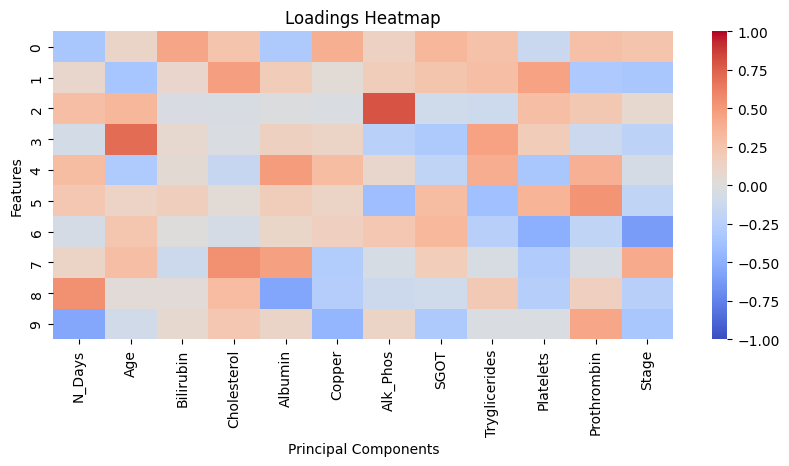

In [33]:
# Make a heatmap of loadings to see patterns more easily
plt.figure(figsize=(10, 4))
sns.heatmap(loadings_df, cmap="coolwarm", annot=False, fmt=".2f", vmin=-1, vmax=1)
plt.title('Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()

In [34]:
# Check the amount of variance explained
sum(pca.explained_variance_ratio_)

0.9123532343477779

To get to 90% variance we need 10 out of 12 PCAs which is not great and so there is no obvious way to reduce the numebr of original columns using this information.

## Data exploration of age

Age looks to be a significant factor in predicting CL. We wanted to explore age further and see whether we should include it as a continuous or discrete variable. Often medical decisions are made based on whether a person is a child, adult or elder. When we split the data by child, adult and elder we found that there were no children in the study and there was significant different in class structure between adult and elder (see stacked bar chart). We used https://service-manual.nhs.uk to decide on thresholds.

In [35]:
# Define the threshold for distinguishing children and adults
threshold_child = 4749
threshold_elder = 23719

# Define a function to categorize age based on thresholds
def categorize_age(age):
    if age <= threshold_child:
        return 'Child'
    elif age <= threshold_elder:
        return 'Adult'
    else:
        return 'Elder'

# Apply the function to create the 'Age_Range' column
train['Age_Range'] = train['Age'].apply(categorize_age)

train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Age_Range
0,0,999,1,21532,1,1,1,1,N,2.3,316,3.35,172,1601.0,179.80,63,394,9.7,3,D,Adult
1,1,2574,0,19237,0,1,1,1,N,0.9,364,3.54,63,1440.0,134.85,88,361,11.0,3,C,Adult
2,2,3428,0,13727,0,1,0,0,Y,3.3,299,3.55,131,1029.0,119.35,50,199,11.7,4,D,Adult
3,3,2576,0,18460,0,1,1,1,N,0.6,256,3.50,58,1653.0,71.30,96,269,10.7,3,C,Adult
4,4,788,0,16658,0,1,0,1,N,1.1,346,3.65,63,1181.0,125.55,96,298,10.6,4,C,Adult


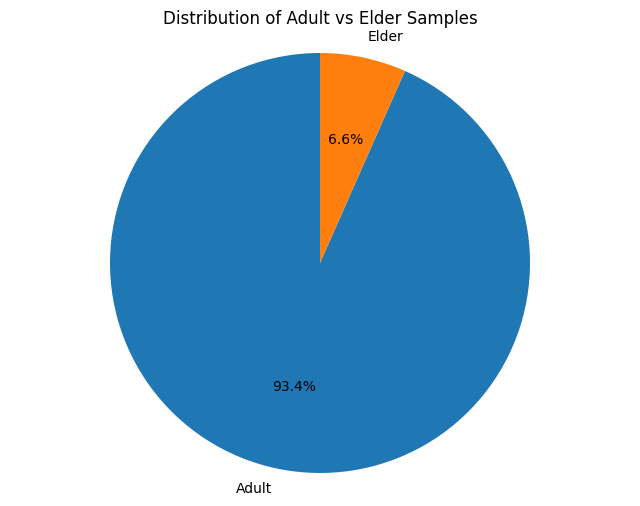

In [36]:
# Count the occurrences of each age range
age_range_counts = train['Age_Range'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(age_range_counts, labels=age_range_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Adult vs Elder Samples')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

<Figure size 1000x600 with 0 Axes>

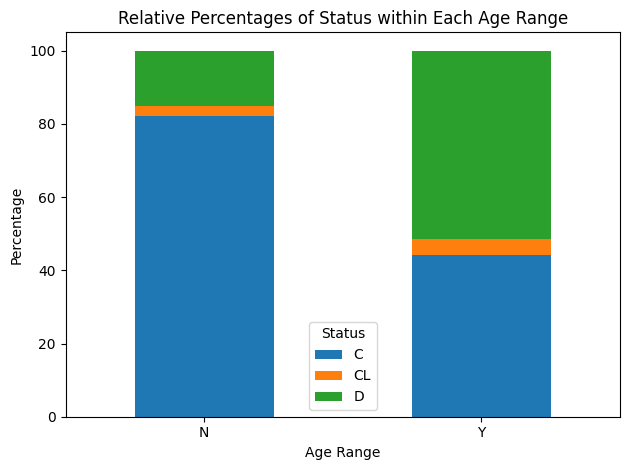

In [37]:
# Calculate the relative frequencies
relative_frequencies = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the stacked bar graph
plt.figure(figsize=(10, 6))
relative_frequencies.plot(kind='bar', stacked=True)
plt.title('Relative Percentages of Status within Each Age Range')
plt.xlabel('Age Range')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

The question is whether making these new categories is actually appropriate. To look at how age affects class we binned the ages into 10 bins and plotted the proportion in each class. The changes with age look relatively linear so we decide to keep age as a continuous variable rather than binning into adult and elder.

In [38]:
# bin by age
train['age_bin'] = pd.qcut(train['Age'], q=10, labels=False)

In [39]:
# Group by percentile_bin and category, then count occurrences of each category
result = train.groupby(['age_bin', 'Status'],observed=True).size().reset_index(name='count')

# Pivot the DataFrame to get categories as columns
result_pivot = result.pivot(index='age_bin', columns='Status', values='count')

# Fill NaN values with 0 (if a category is not present in a percentile bin)
result_pivot.fillna(0, inplace=True)

# Convert any float counts to integers
result_pivot = result_pivot.astype(int)

# Scale by row sums to get proportion in each class
row_sums = result_pivot.sum(axis=1)
result_scaled = result_pivot.div(row_sums, axis=0)

In [40]:
# making data frame long form for easier plotting
result_long = result_scaled.reset_index().melt(id_vars='age_bin', var_name='Status', value_name='count')

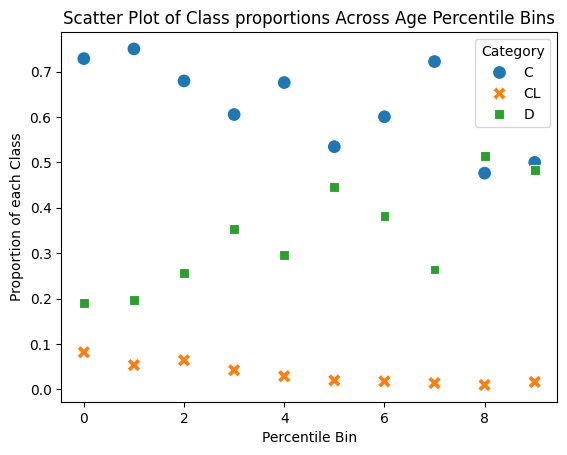

In [41]:
sns.scatterplot(data=result_long, x='age_bin', y='count', hue='Status', style='Status', s=100)
plt.title('Scatter Plot of Class proportions Across Age Percentile Bins')
plt.xlabel('Percentile Bin')
plt.ylabel('Proportion of each Class')
plt.legend(title='Category')

## Data Exploration conclusion

We eliminate:

* Alk\_Phos, Triglyceride by box plots
* Drug, Spiders by stacked bar chart
* Cholesterol, Ascites, ID, and Albumin by elastic net and box plots
        
We decided to keep:
* N_Days, Age, Sex, Hepatomegaly, Edema, Bilirubin, Albumin, Copper, SGOT, Platelets, Prothrombin, Stage
  
Summarising what we decided to get rid of:
* Alk\_Phos, Tryglicerides, Drug, Spiders, Cholesterol, Ascites, id, and Albumin

We need to log:
* Bilirubin, Copper, SGOT and Prothrombin.

We do not include id in the model but retain the information, which is needed for testing our model performance.

We keep age as a continuous variable, as classes show a linear relationship with age and it uses less variables than if we made it categorical.

# Training Models and Pipeline section

# Pipeline

Based upon the Exploratory Data Analysis we have chosen our features. Below is the pipeline which will fully prepare a data frame to be used with our models.

In [42]:
df = pd.read_csv('train.csv')
df.head()

def full_pipeline(df, test = False):
   # No missing data to drop
   
   # Columns that should be Categorical
   columns_to_convert_cat = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders','Edema']
   df[columns_to_convert_cat] = df[columns_to_convert_cat].astype('category')
   # Columns that should be Integer
   columns_to_convert_int = ['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets','Stage']
   df[columns_to_convert_int] = df[columns_to_convert_int].astype('int64')


   #Dropping features not used
   df.drop(['Alk_Phos', 'Cholesterol', 'Ascites',  'Albumin', 'Tryglicerides', 'Drug', 'Albumin', 'Spiders'], axis = 1, inplace = True)

   #Log transform Bilirubin and Copper based on the EDA
   df['Bilirubin_log'] = np.log(df['Bilirubin'])
   df['Copper_log'] = np.log(df['Copper'])

   df.drop(['Bilirubin', 'Copper'], axis = 1, inplace = True) 

   if not test:
      #Some algorithms require response to be numerical as below
      df['Status'] = df['Status'].astype('category')
      mapping = {'C': 0, 'CL': 1, 'D': 2}
      df['Status'] = df['Status'].map(mapping)        

   #One hot encode categorical, non ordinal features and scale the numerical features
   categorical_attributes = ['Hepatomegaly', 'Edema', 'Sex']
   numerical_attributes = ['Stage', 'N_Days', 'Bilirubin_log', 'Copper_log', 'SGOT', 'Platelets', 'Prothrombin', 'Age']

   encoding_pipeline = ColumnTransformer([
      ("numerical", StandardScaler(), numerical_attributes),
      ("categorical", OneHotEncoder(sparse_output=False), categorical_attributes)
      ], remainder = 'passthrough')

   encoding_pipeline.set_output(transform="pandas")

   df_encoded = encoding_pipeline.fit_transform(df)
   
   #Shuffle the data if not the test (order matters for Kaggle)
   if not test:
      df_shuffled = shuffle(df_encoded, random_state = 5059)
      return df_shuffled
   
   else:
      return df_encoded


In [43]:
#Run the training data through the pipeline

df_encoded = full_pipeline(df)
df_encoded.head()

,numerical__Stage,numerical__N_Days,numerical__Bilirubin_log,numerical__Copper_log,numerical__SGOT,numerical__Platelets,numerical__Prothrombin,numerical__Age,categorical__Hepatomegaly_N,categorical__Hepatomegaly_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y,categorical__Sex_F,categorical__Sex_M,remainder__id,remainder__Status
4172,-1.191649,-1.181882,0.782495,0.860570,-0.094380,-0.014052,-0.805263,0.596200,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4172,1
2060,-0.037522,-0.219504,-0.295704,0.100939,1.685776,-0.597175,-0.549406,-1.411830,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2060,2
7405,-1.191649,-1.088660,0.558641,0.138740,0.049098,0.797747,0.346095,-1.221326,1.0,0.0,1.0,0.0,0.0,1.0,0.0,7405,0
1390,-0.037522,0.235638,-1.116204,0.228645,-0.347517,-1.145997,-1.316978,0.505433,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1390,0
3275,-0.037522,1.968467,-0.926473,-0.889508,-1.262704,0.180323,-0.037691,-1.767834,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3275,2


## Splitting the data into training and validation sets

We have separate variables for the entirety of the training data for k-fold cross validation and the final model, and a train and validation split to assess the generalisation error of our models as we fit them. We picked a split of 80:20.

In [44]:
full_labels = df_encoded['remainder__Status'].copy()
full_set = df_encoded.drop(['remainder__Status', 'remainder__id'], axis = 1)

train_and_val = train_test_split(df_encoded, shuffle = True, random_state = 5059, test_size = 0.2, stratify = df_encoded['remainder__Status']) # Splitting the data

train_set = train_and_val[0]
val_set = train_and_val[1]
train_labels = train_set['remainder__Status'].copy()
train_set.drop(['remainder__Status', 'remainder__id'], axis = 1, inplace = True)
val_labels = val_set['remainder__Status'].copy()
val_set.drop(['remainder__Status', 'remainder__id'], axis = 1, inplace = True)

# Model Training

We are going to train several models and evaluate each of them using the log-loss metric described in the coursework instructions. Thankfully, this metric is built in sklearn as 'log_loss'.

Each matrix below is known as a confusion matrix and represents the classifications made by each model. We want there to be the most classifications along the diagonal as these represent correct decisions. The left side of the matrix represents the true value of each classification and the bottom represents what the model predicted.

We have focussed on ensemble methods due to their high performance and ability to train several models and pick the best. 

# AdaBoost

A boosting method. We have used a decision tree as the base classifier.

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


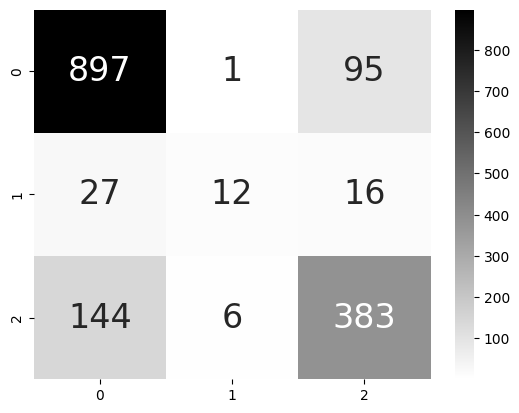

The log loss score: 1.054257226975409


In [45]:
adaboost_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm="SAMME.R", learning_rate=1, random_state=5059)

adaboost_classifier.fit(train_set, train_labels)

ada_classifications = adaboost_classifier.predict(val_set)
matrix = confusion_matrix(val_labels, ada_classifications)


plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()

ada_probabilities = adaboost_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, ada_probabilities)))

## XGBoost
Another boosting method. The objective function specified is for multiclass classification. 

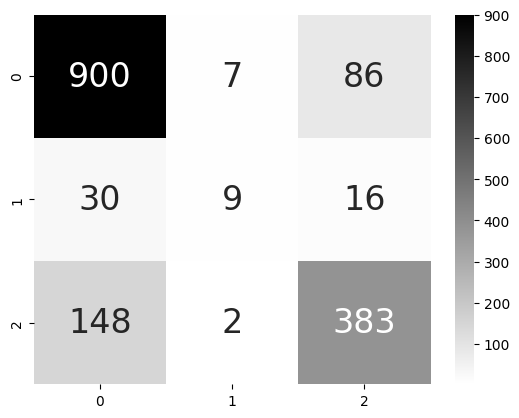

The log loss score: 0.509780616679422


In [46]:
xgb_classifier = xgb.XGBClassifier(objective="multi:softprob", num_class = 3, eval_metric = log_loss, random_state=5059)

xgb_classifier.fit(train_set, train_labels)

xgb_classifications = xgb_classifier.predict(val_set)

matrix = confusion_matrix(val_labels, xgb_classifications)


plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()

xgb_probabilities = xgb_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, xgb_probabilities)))


## Random Forest

Another ensemble method. We do some brief analysis to pick a sensible number of trees for our initial model. The graph below suggests no improvement past 750 trees in the forest, the large disparity between validation log loss and training log loss implies a possible overfit. This can be looked at in the fine tuning phase as this is one of the better performing models.

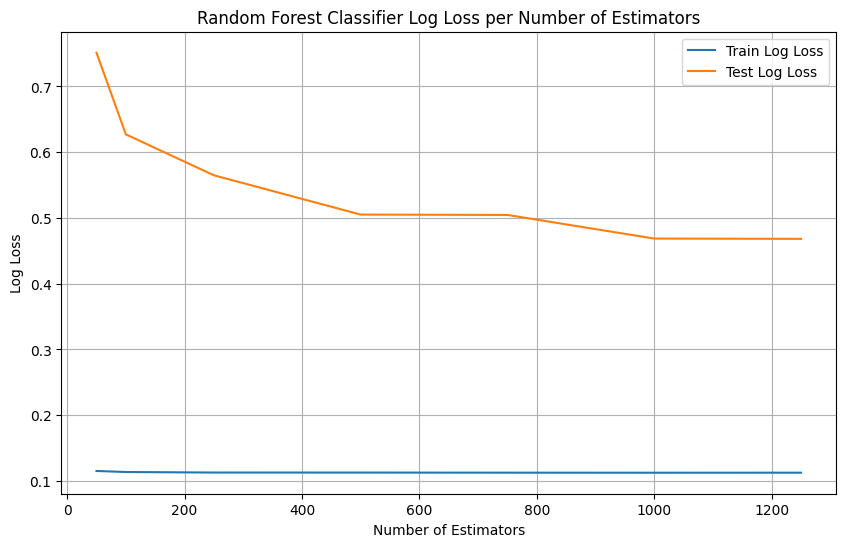

In [47]:
n_estimators_range = [50, 100, 250, 500, 750, 1000,1250]

# Initialize lists to store log loss values
log_losses_train = []
log_losses_test = []

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=5059)
    rf.fit(train_set, train_labels)

    log_loss_train = log_loss(train_labels, rf.predict_proba(train_set))
    log_loss_test = log_loss(val_labels, rf.predict_proba(val_set))
    

    log_losses_train.append(log_loss_train)
    log_losses_test.append(log_loss_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, log_losses_train, label='Train Log Loss')
plt.plot(n_estimators_range, log_losses_test, label='Test Log Loss')
plt.title('Random Forest Classifier Log Loss per Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

Using the 1000 trees recommended by the above graph we can see that we obtain a strong model compared to those we have seen thus far.

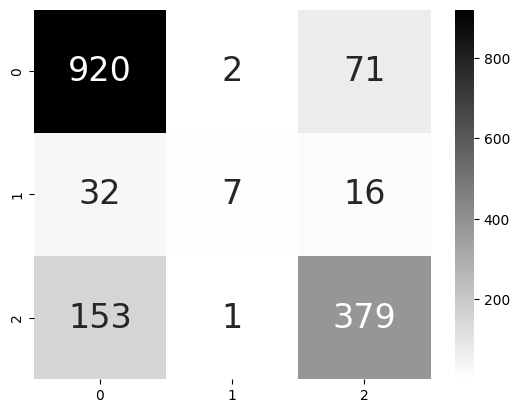

The log loss score: 0.4686899802958091


In [48]:
forest_classifier = RandomForestClassifier(n_estimators = 1000, random_state=5059)

forest_classifier.fit(train_set, train_labels)

forest_classifications = forest_classifier.predict(val_set)
matrix = confusion_matrix(val_labels, forest_classifications)
plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()

forest_probabilities = forest_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, forest_probabilities)))

## SVM

These are particulaly slow to train as we need the probabilities to evaluate the log loss so extra work is done when training the SVM. This means we need to consider carefully picking an SVM to take further, as any hyperparameter gridsearch would be a costly process in time and money.

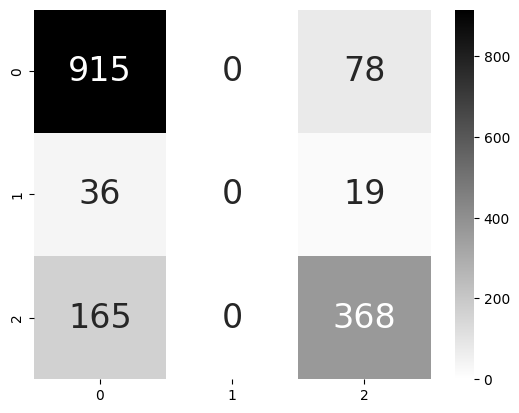

The log loss score: 0.5212655228143017


In [49]:
svm_classifier = SVC(probability = True, tol = 1e-5, random_state=5059)

svm_classifier.fit(train_set, train_labels)
svm_classifications = svm_classifier.predict(val_set)
matrix = confusion_matrix(val_labels, svm_classifications)
plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()

svm_probabilities = svm_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, svm_probabilities)))


## Decision Tree

Some parameter values are set to prevent overfitting due to sklearn's extreme defaults for decision tree classifiers. We will plot a range of max_depth, as this is the key hyperparameter, to ensure we accurately represent the usefulness of a decision tree in this case.

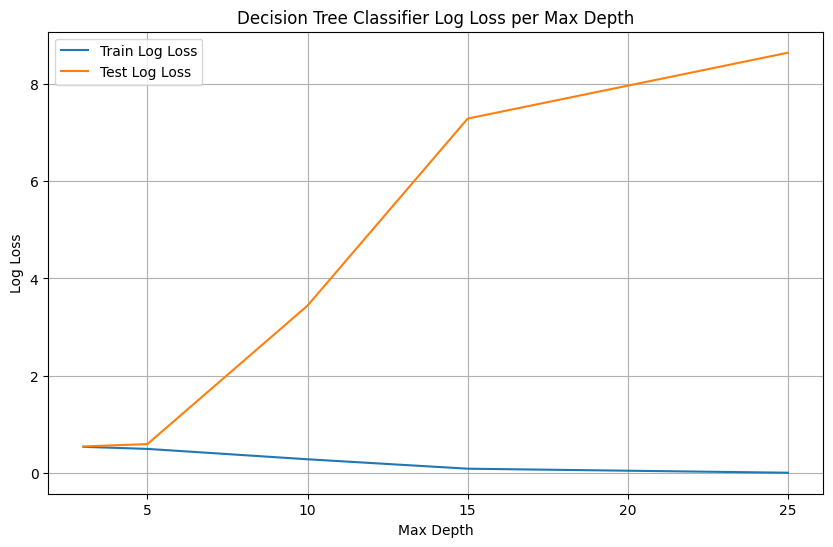

In [50]:
max_depth_range = [3,5, 10, 15, 25]


log_losses_train = []
log_losses_test = []

for max_depth in max_depth_range:
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=5059)
    tree.fit(train_set, train_labels)
    
    # Calculate log loss for train and test sets
    log_loss_train = log_loss(train_labels, tree.predict_proba(train_set))
    log_loss_test = log_loss(val_labels, tree.predict_proba(val_set))
    
    # Append log loss values to the lists
    log_losses_train.append(log_loss_train)
    log_losses_test.append(log_loss_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, log_losses_train, label='Train Log Loss')
plt.plot(max_depth_range, log_losses_test, label='Test Log Loss')
plt.title('Decision Tree Classifier Log Loss per Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

The graph suggests a smaller max depth to prevent the log loss from rocketing up. We will take the max depth to be 5.

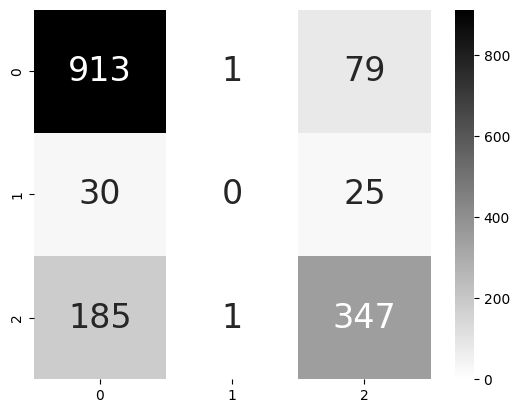

The log loss score: 0.5917724545497874


In [51]:
tree_classifier = DecisionTreeClassifier(max_depth = 5, min_samples_split=10, random_state=5059)

tree_classifier.fit(train_set, train_labels)

tree_classifications = tree_classifier.predict(val_set)
matrix = confusion_matrix(val_labels, tree_classifications)
plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()

tree_probabilities = tree_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, tree_probabilities)))

Based on the log_loss metric and without finetuning or any method of dealing with imbalanced data, the SVM and the Random Forest seem to be the best performing. 

# Finetuning

XGBoost and Random Forest seem to be our most promising models. So we will fine tune them. 

## XGBoost

We first consider the learning curves for the train and validation sets for the XGBoost. We see that the model is learning too quickly and leading to overfitting. Inspiration and information found here: https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e.

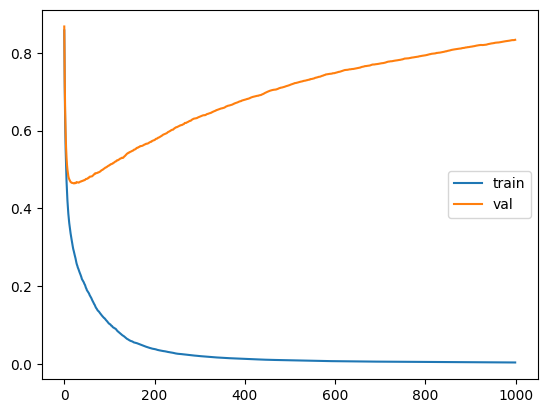

In [52]:
xgb_classifier = xgb.XGBClassifier(objective="multi:softprob", n_estimators = 1000, eval_metric='mlogloss', random_state=5059)

evalset = [(train_set, train_labels), (val_set,val_labels)]

xgb_classifier.fit(train_set, train_labels, eval_set=evalset, verbose = False)

results = xgb_classifier.evals_result()

plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='val')
plt.legend()
plt.show()

To help with this, we will reduce the learning rate eta. We will also introduce early stopping after 10 successive iterations of no improvement in log loss score on our validation set. Our value for n_estimators seems to be okay for the learning rate, as the validation log loss plateaus before we stop iterating.

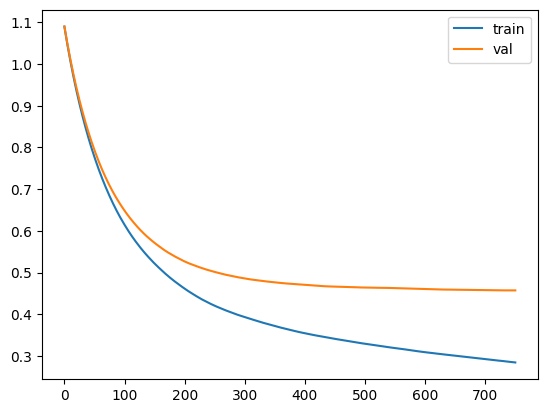

In [53]:
xgb_classifier = xgb.XGBClassifier(objective="multi:softprob", n_estimators = 1000, eta = 0.01,early_stopping_rounds = 10, eval_metric='mlogloss', random_state=5059)

evalset = [(train_set, train_labels), (val_set,val_labels)]

xgb_classifier.fit(train_set, train_labels, eval_set=evalset, verbose = False)

results = xgb_classifier.evals_result()

plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='val')
plt.legend()
plt.show()

That improved the situation! We will now look to fine tune some other parameters. These control various aspects of the model including regularisation to prevent overfitting, the maximum depth of the trees, the proportion of the rows used to train each tree, etc. We use a grid search with cross validation on the entire training set to ensure we do not overfit to the validation set.

In [54]:
param_grid = {
    'max_depth': [3, 6, 9],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.3, 0.7, 1],
    'lambda': [1, 5, 10], # L2 regularization term on weights (Ridge regression)
    'alpha': [0, 1, 5] # L1 regularization term on weights (Lasso regression)
}

xgb_classifier = xgb.XGBClassifier(objective="multi:softprob", n_estimators = 1000, eta = 0.01, eval_metric='mlogloss', random_state=5059)

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='neg_log_loss', n_jobs=-1)
grid_search.fit(full_set, full_labels)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

/opt/homebrew/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'alpha': 0, 'colsample_bytree': 0.3, 'lambda': 1, 'max_depth': 9, 'subsample': 0.5}
Best Score: -0.4346485757677673


We can see the best parameters which achieved a log_loss of 0.4346 averaged across the cross validation process. GridsearchCV uses stratified K-Fold cross validation as default so no need to worry about our minority classes not being represented.

In [55]:
best_xgb_classifier = grid_search.best_estimator_

Here, we reintroduce the early stopping to ensure we get the best model with the lowest log loss.

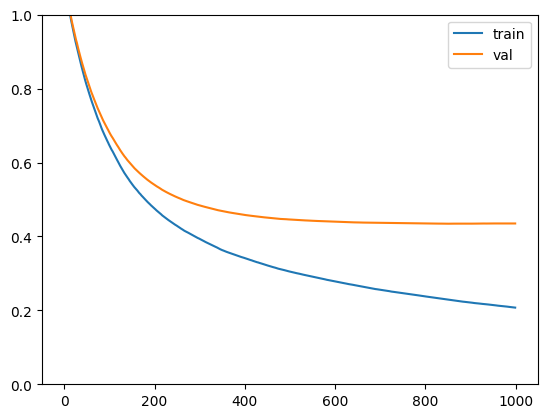

In [56]:
evalset = [(train_set, train_labels), (val_set,val_labels)]

best_xgb_classifier.fit(train_set, train_labels, eval_set=evalset, verbose = False)

results = best_xgb_classifier.evals_result()

plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='val')
plt.ylim(0,1)
plt.legend()
plt.show()

The matrix below demonstrates that the model is still struggling to classify our minority class (CL) but is reasonable with the others. The graph above also shows that the model has not overfit at this point as the resubstitution log loss remains above 0.2. The confusion matrix below is from resubstituting the training set back in, and it also does not seem to support this model being overfit.

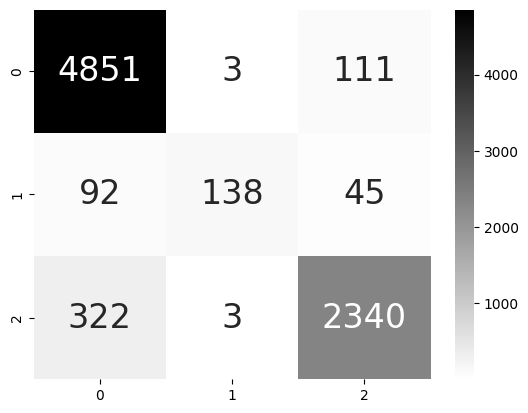

In [57]:
best_xgb_classifier.fit(full_set, full_labels)

best_classifications = best_xgb_classifier.predict(full_set)

matrix = confusion_matrix(full_labels, best_classifications)

plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()


We reproduce the confusion matrix for the validation set.

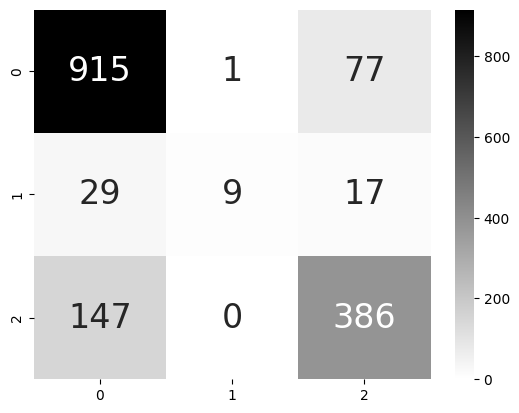

The log loss score: 0.43506050931142004


In [58]:
best_xgb_classifier.fit(train_set, train_labels)

best_classifications = best_xgb_classifier.predict(val_set)

matrix = confusion_matrix(val_labels, best_classifications)

plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()

xgb_probabilities = best_xgb_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, xgb_probabilities)))


## Random Forest

The grid search does not provide us with as much of an improvement in log loss as it did for XGBoost. Similar cross-fold validation is used once again. The final confusion matrix shows the final random forest model. It is extremely reluctant to predict CL.

In [ ]:


forest_classifier = RandomForestClassifier(random_state=5059)

param_grid = {
 'max_depth': [10, 15, 20],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [5,10,15],
 'min_samples_split': [5,10,15],
 'n_estimators': [1000,1250,1500]}


grid_search_forest = GridSearchCV(estimator=forest_classifier, param_grid=param_grid, cv=5, scoring='neg_log_loss', n_jobs=-1)
grid_search_forest.fit(full_set, full_labels)

best_parameters_forest = grid_search_forest.best_params_
best_score_forest = grid_search_forest.best_score_


        


In [63]:
print(best_score_forest)
print(best_parameters_forest)

-0.4678801730756004
{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1000}


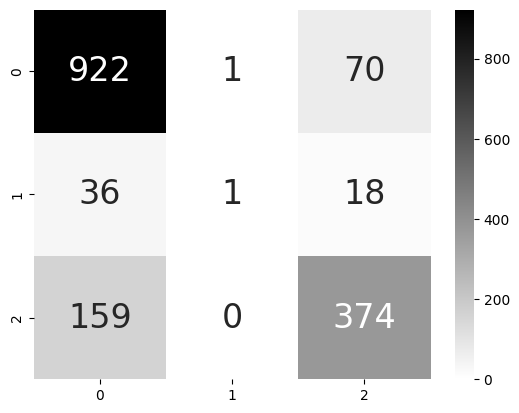

The log loss score: 0.4656245438070868


In [64]:
best_forest = grid_search_forest.best_estimator_

best_forest.fit(train_set, train_labels)

best_forest_classifications = best_forest.predict(val_set)

matrix = confusion_matrix(val_labels, best_forest_classifications)

plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='binary', annot_kws={"fontsize":24})
plt.show()

forest_probabilities = best_forest.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, forest_probabilities)))

## Which model do we prefer?

Due to its lower log loss score and the fact that it does not seem overfit, we prefer the XGBoost model with early stopping to ensure we get the best model. This model has a log loss of 0.444 on the validation set. Although the model is reluctant to predict the minority class, it has a strong ability to predict whether the observation of the individual with liver cirrhosis ends with death, or does not. This could be useful in several medical use cases where identifying those most at risk of death is key. However, for a use case of identifying individuals who may most benefit from a transplant it is not as useful. This would likely require more data as the data imbalancing methods seen in the following section do not provide much of an improvement. 

Therefore the final model trained on all the training data is as follows:



In [65]:

params = {'alpha': 0, 'colsample_bytree': 0.3, 'lambda': 1, 'max_depth': 9, 'subsample': 0.5, 'n_estimators' : 1000, 'eta' : 0.01, 'eval_metric':'mlogloss', 'random_state':5059}

best_xgb_classifier = xgb.XGBClassifier(objective = "multi:softprob", **params)

best_xgb_classifier.fit(full_set, full_labels)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000, ...)

## Feature Importance in XGBoost Model

It is important that the client is able to focus their data collection on the features most important to the model. This is because data collection can be complex and expensive. It is plausible to assume that medical data is especially hard to procure due to the cost of the tests, the experts involved with conducting them, the costs of such data collection, and the fact that you have to 'wait' for someone to present with the condition to collect their data. 

To ensure the client can do this, we will analyse the feature importance in our final model.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

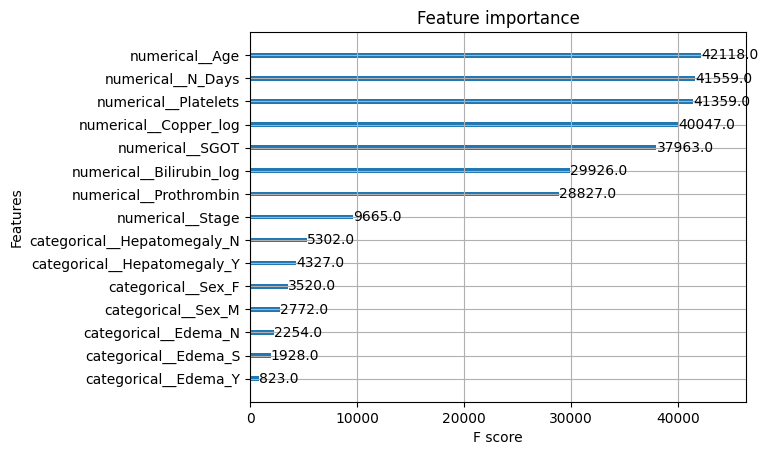

In [66]:
plot_importance(best_xgb_classifier)

We can see that the number of days, the level of SGOT, the Platelet level, the age of the patient, the urine Copper level, the Bilirubin level, the Prothrombin time are the most important features to the model. The stage of the cancer, age group, sex of the patient, presence of Hepatomegaly, and category of Edema are also key. XGBoost models will only list the features used in the splits of the trees being trained and therefore not all features are listed here. These features were identified to be important in our EDA which supports the decisions made by the XGBoost model. 

# Methods of dealing with the imbalanced classes

We will consider two methods: SMOTE and ADASYN, both oversampling techniques. 

SMOTE operates by creating synthetic samples of the minority class(es) to balance the data set. It does not duplicate rows attributed to the minority class but instead produces the synthetic data by using a k-Nearest Neighbours algorithm to interpolate each feature using data close to a given instance. 

ADASYN is different as it generates the synthetic samples adaptively, using a weighted distribution which allows it to focus on instances more difficult to learn and classify.  

Information about these techniques was found here: (https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/) (https://ieeexplore.ieee.org/document/4633969)

We are going to focus on applying these techniques to our final finetuned XGBoost model.


## SMOTE

In [67]:
smote = SMOTE(k_neighbors = 5, random_state=5059)

train_set_smote, train_labels_smote = smote.fit_resample(train_set, train_labels)

train_labels_smote.value_counts()

remainder__Status
0    3972
1    3972
2    3972
Name: count, dtype: int64

As we can see SMOTE has balanced the number of instances in the training set associated with each class. 

In [68]:
best_xgb_classifier.fit(train_set_smote, train_labels_smote)

xgb_probabilities = best_xgb_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, xgb_probabilities)))

The log loss score: 0.4648496142044904


The log loss score has increased from before, indicating a worse model. To be sure SMOTE is not improving our situation, we will tune the hyperparameter of k_neighbors.

In [69]:
k_values = [1,2,3,4,5,6,7,8]

for k in k_values:
    smote = SMOTE(k_neighbors = k, random_state=5059)
    train_set_smote, train_labels_smote = smote.fit_resample(train_set, train_labels)

    best_xgb_classifier.fit(train_set_smote, train_labels_smote)
    xgb_probabilities = best_xgb_classifier.predict_proba(val_set)

    print('The log loss score for k = ' + str(k) + ': ' + str(log_loss(val_labels, xgb_probabilities)))

    

The log loss score for k = 1: 0.4596984343081763
The log loss score for k = 2: 0.46003934607794983
The log loss score for k = 3: 0.4628934829171914
The log loss score for k = 4: 0.4650966275116201
The log loss score for k = 5: 0.4648496142044904
The log loss score for k = 6: 0.4638427168999045
The log loss score for k = 7: 0.46485361154819416
The log loss score for k = 8: 0.4633387362140075


This means that k = 3 provides the best performance but it is stil a downgrade from not using SMOTE. We will try ADASYN to see if that makes an improvement.

## ADASYN

Below we can see that ADASYN has rebalanced the training set and has focused on the minority class (1 aka CL).

In [70]:
adasyn = ADASYN(random_state = 5059)

train_set_ada, train_labels_ada = adasyn.fit_resample(train_set, train_labels)

train_labels_ada.value_counts()

remainder__Status
1    4032
0    3972
2    3710
Name: count, dtype: int64

In [71]:
best_xgb_classifier.fit(train_set_ada, train_labels_ada)

xgb_probabilities = best_xgb_classifier.predict_proba(val_set)

print('The log loss score: ' + str(log_loss(val_labels, xgb_probabilities)))

The log loss score: 0.46982836874272044


Once again, the log loss has increased which indicated a worse model. We will check different values for n_neighbors to make sure that the hyperparameter is not causing the problem.

In [72]:
k_values = [1,2,3,4,5,6,7,8]

for k in k_values:
    adasyn = ADASYN(n_neighbors= k, random_state=5059)
    train_set_ada, train_labels_ada = adasyn.fit_resample(train_set, train_labels)

    best_xgb_classifier.fit(train_set_ada, train_labels_ada)
    xgb_probabilities = best_xgb_classifier.predict_proba(val_set)

    print('The log loss score for k = ' + str(k) + ': ' + str(log_loss(val_labels, xgb_probabilities)))

    

The log loss score for k = 1: 0.4611421919664658
The log loss score for k = 2: 0.4645227419829043
The log loss score for k = 3: 0.4636052324887529
The log loss score for k = 4: 0.46831377549661435
The log loss score for k = 5: 0.46982836874272044
The log loss score for k = 6: 0.4709553036271728
The log loss score for k = 7: 0.46824839653814243
The log loss score for k = 8: 0.46800292250698194


Once again none of the values have resulted in the ADASYN method improving the model. 

## Why are these methods not improving our XGBoost model?

Both of these methods are different ways of oversampling the minority class of our training set. The original paper on SMOTE (https://doi.org/10.48550/arXiv.1106.1813) was only tested on a few classifiers, specifically C4.5, Ripper and Naive Bayes. These are known as weak classifiers. A far more recent paper from 2022 (https://doi.org/10.48550/arXiv.2201.08528) studied the effectiveness of SMOTE, ADASYN and other methods with respect to strong, state of the art classifiers such as XGBoost. In that paper, the authors note that theoretical thinking has concluded that optimising objective functions such as log loss, which we use here, may not be as impacted by imbalanced data and do not lead models to begin to focus too much on classifying the majority classes. They conclude that methods such as SMOTE and ADASYN do not provide a significant boost to state of the art classifiers, such as the XGBoost model used above. 

Therefore, it is important to consider the challenge of data imbalance on a case by case basis by considering both the objective function and the models in use, rather thank rushing in and using a popular ML technique.

# Testing our model

Below we read in the test data and pass it through our pipeline. We save the ids separately in order to pass the predictions back through to Kaggle.

In [73]:
test_df = pd.read_csv('test.csv')
encoded_test_df = full_pipeline(test_df, test = True)
encoded_test_df.head()

,numerical__Stage,numerical__N_Days,numerical__Bilirubin_log,numerical__Copper_log,numerical__SGOT,numerical__Platelets,numerical__Prothrombin,numerical__Age,categorical__Hepatomegaly_N,categorical__Hepatomegaly_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y,categorical__Sex_F,categorical__Sex_M,remainder__id
0,-1.211516,1.656608,-0.202214,0.050072,0.782524,1.895231,-0.041463,0.342186,0.0,1.0,1.0,0.0,0.0,1.0,0.0,7905
1,-1.211516,0.395038,-0.292379,0.525907,0.782524,-0.422762,-0.798430,-0.983033,1.0,0.0,1.0,0.0,0.0,1.0,0.0,7906
2,1.125074,-1.829045,0.327127,-0.395887,-0.895372,-0.582624,2.986409,-1.492582,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7907
3,-1.211516,0.268052,-0.920484,-0.576159,0.244331,0.068241,-0.041463,0.561521,1.0,0.0,1.0,0.0,0.0,1.0,0.0,7908
4,-2.379810,-0.389878,-0.042476,0.851588,0.233097,-0.491274,-1.050753,0.950520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,7909


In [74]:
test_ids = encoded_test_df['remainder__id'].copy()
encoded_test_df.drop(['remainder__id'], axis = 1, inplace = True)
encoded_test_df.head()

,numerical__Stage,numerical__N_Days,numerical__Bilirubin_log,numerical__Copper_log,numerical__SGOT,numerical__Platelets,numerical__Prothrombin,numerical__Age,categorical__Hepatomegaly_N,categorical__Hepatomegaly_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y,categorical__Sex_F,categorical__Sex_M
0,-1.211516,1.656608,-0.202214,0.050072,0.782524,1.895231,-0.041463,0.342186,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,-1.211516,0.395038,-0.292379,0.525907,0.782524,-0.422762,-0.798430,-0.983033,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.125074,-1.829045,0.327127,-0.395887,-0.895372,-0.582624,2.986409,-1.492582,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,-1.211516,0.268052,-0.920484,-0.576159,0.244331,0.068241,-0.041463,0.561521,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-2.379810,-0.389878,-0.042476,0.851588,0.233097,-0.491274,-1.050753,0.950520,0.0,1.0,1.0,0.0,0.0,1.0,0.0


Refitting our best model on all the data as it has been previously refit onto the SMOTE/ADASYN data.

In [75]:
best_xgb_classifier.fit(full_set, full_labels)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000, ...)

Here we make the predictions and place all the relevant data into a dataframe of the correct form.

In [76]:
test_probabilities = best_xgb_classifier.predict_proba(encoded_test_df)
probabilities_df = pd.DataFrame(test_probabilities, columns=['Status_C', 'Status_CL', 'Status_D'])
results_df = pd.concat([test_ids, probabilities_df], axis=1)
results_df = results_df.rename(columns={'remainder__id': 'id'})
results_df.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.495066,0.012775,0.492159
1,7906,0.803932,0.059472,0.136596
2,7907,0.021928,0.018394,0.959678
3,7908,0.986088,0.002664,0.011248
4,7909,0.857346,0.030638,0.112016


In [77]:
# Saving the probabilities to a CSV to submit to Kaggle.
results_df.to_csv('test_probabilities_group_5.csv', index=False)

# Kaggle Score

![Alt Text](kagglescore.jpeg)

As can be seen above, our model achieves scores of 0.44953 and 0.44710. This is better than random chance which has a log loss of 0.76424. This means our model has some real predictive power. Moreover, our model gets close to the minimum log loss on Kaggle (around 0.39).

# Data Imputation Section

## Read the data

In [78]:
# on lab machines
# train = pd.read_csv("/cs/studres/ID5059/Coursework/Coursework-2/data/train.csv", index_col=False)

train = pd.read_csv("train.csv", index_col=False)

## Convert data to correct types

In [79]:
# Columns that should be Categorical
columns_to_convert_cat = ['Drug','Sex', 'Ascites', 'Hepatomegaly', 'Spiders','Edema', 'Status']

# Convert
train[columns_to_convert_cat] = train[columns_to_convert_cat].astype('category')

# Columns that should be Integer
columns_to_convert_int = ['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets','Stage']

# Convert
train[columns_to_convert_int] = train[columns_to_convert_int].astype('int64')

## Scale numeric values

We scale the values, so that no variable has an adverse effect on our imputation metric. 

In [80]:
# make scaler instance
scaler = StandardScaler()

# Select numeric columns
numeric_cols = train.select_dtypes(include=['number']).columns

# Scale numeric columns
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])

## Drop the response

Seperating the data used for imputation and the labels stored in a variable to re-attach them later on.

In [81]:
# drop response
y_train = train['Status']
x_train = train.drop(columns = "Status")

## Remove values

We remove values by giving each cell in the data frame a 1 with probability 0.9 if we want to keep it and a 0 if we want to remove the data, so we should lose 10% of the data.

In [82]:
# set the seed
np.random.seed(5059)

# Give value of 1 with 90% for each value in dataframe - 0s are then removed
keep = np.random.binomial(n=1, p=0.9, size=x_train.shape)
train_w_na = x_train.mask(keep == 0)
train_w_na.to_csv('train_w_na.csv', index=False)

Verifiying that the correct proportion of data has been removed.

In [83]:
# Check the proportion of NA values in the new data
train_w_na.isna().sum().sum()  / (train_w_na.shape[0] * train_w_na.shape[1])

0.10006325110689437

### Splitting Categorical and Numeric Data

This has been done since the evaluation metrics for each type of data is distinct.

In [84]:
def split_data_cat_num(data):
    data_cat = data.select_dtypes(include=['object', 'category'])
    data_num = data.select_dtypes(include=['number'])
    return(data_cat, data_num)

## Imputation

We researched some common imputation methods and came accross the following:

* A simple imputation using mean / mode / median
* Multiple Imputation by Chained Equations (MICE) / iterative imputer (similar to MICE)
* k-Nearest Neighbors (KNN)
* MissForest

Initial analysis using the a simple imputation method gave poor results, so we elected to only investigate MICE, MissForest and KNN as our best 3 methods. 

Since we are removing data randomly we have 'Missing at Random' (MAR) data. Before we carried out the imputation we looked at some papers to see how others assessed imputation methods that were used on MAR data.

https://bmjopen.bmj.com/content/3/8/e002847 suggests:

* uses the average relative error for continuous variables
* misclassification error for categorical variables

Another source:
https://lgreski.github.io/datasciencedepot/references/a-comparison-of-six-methods-for-missing-data-imputation-2155-6180-1000224.pdf

* uses RMSE for the continuous variables
* other misclassifciation errors for categorical.

RSME penalizes large error more than MAE (https://gmd.copernicus.org/preprints/7/1525/2014/gmdd-7-1525-2014.pdf), so we decided to use RSME for the continuous variables and missclassification error for the categorical variables.

We also measure how well the imputation methods perform by using the imputed data in our final model and comparing the log loss on the validation set to the true data and the other imputation methods.


## Miss Forest

Documentation: (https://pypi.org/project/MissForest/)

Using information found in this paper:
Daniel J. Stekhoven, Peter Bühlmann, MissForest—non-parametric missing value imputation for mixed-type data, Bioinformatics, Volume 28, Issue 1, January 2012, Pages 112–118, (https://doi.org/10.1093/bioinformatics/btr597)

This method of imputation is non-parametric in nature, meaning it doesn't rely on their being an the data it is imputing from having any underlying distribution. This is benificial since, we are unsure if this is assumption could have been met if we were using a parametric method. A benefit of this method is that it handles both numeric and categorical data natively, and doesn't require a bespoke approach as will be seen in other methods to handle the categorical data type. Below will outline a summary of the general appraoch that the method carries out;

* **Initialization**: The first step of the method, starts by imputing all the values of missing data using a simple imputation method, for the numeric columns this being mean or median and for the categorical this being the mode of the column.
* **Feature Ordering**: The method then orders the feature from the features based on the number of imputed entries, number 1 being the feature that required the least imputations.
* **Iterative Imputation**: At this point the MissForest methods iterates over the features based on their ordering and using a *Random Forest* it replaces the simple imputed values with values obtained by the model which predicts the missing values by treating all of the other columns as precitors and builds a model to predict the values. This process is reapeated for each feature in the order specified in the previous step.
* **Convergence Check**: This process of iterative imputation continues repeatidly until a given convergence check is met, commonly this could be a check to see how similar the imputed values are to their previous iterations and if the difference are below a given threshold the method is considered to be converged.
* **Final Output**: Once either the convergence condition is met or the maximum number of iterations is met, the imputed dataset is returned.

The reason this method is so desirable is because the use of *Random Forests* means that not only is the algorithm able to handle different types of data but in addition it has the ability to handle high-dimensional data.

In [88]:
# A function to use missforest imputer and return impyted data set
def missforest(train_w_na):
    categorical_var = train_w_na.select_dtypes(include=['category']).columns
    numeric_var = train_w_na.select_dtypes(include=['number']).columns
    
    clf = RandomForestClassifier(n_jobs=-1)
    rgr = RandomForestRegressor(n_jobs=-1)
    missf = MissForest(clf, rgr)
    imputed_data_mf = missf.fit_transform(train_w_na, categorical_var)
    return imputed_data_mf

In [89]:
# Get imputed data using missforest imputer
imputed_data_mf = missforest(train_w_na)

## MICE

Documentation: https://cran.r-project.org/web/packages/mice/index.html

Using information found from:
(https://www.machinelearningplus.com/machine-learning/mice-imputation/)

The MICE (*Multiple Imputation by Chained Equations*) method also allows the imputation of both numeric/categorical data. The synopsis of this method its approach to imputing data is that it produces multiple datasets of possible imputations values and then using *Random Forests* (hence the name forest) it compares the datasets to produce a final single imputation. An outline of the algorithm behind the method is shown here;

* **Initial Imputation**: Similar to the previous method it starts by filling in the missing values using simple imputaiton methods.
* **Iterative Imputation Process**: It then iteratives over the imputed values can use different methods, including
*Linear Regression*, *Logistic Regression*, *predictive mean matching* and *polytomous regression imputation* to update the missing value columns based on the other non-missing data. This allows it to be effective at handling complex and non-linear relationships between variables.
* **Random Forest Predictor**: Using an esnemble learning method it produces multiple imputations and then takes the mode/mean for the categorical/numeric imputations respectively.
* **Convergence**: This process is repeated till a stopping condition similar to the previous method is met

We looked at using several MICE implmentations in python and ran into the following problems:

* IterativeImputer form Skicit learn: does not naturally handle categorical data
* MIDASpy: outdated - problems with requiring tensorflow that is no longer available and associated problems
* miceforest: handles categorical data via KNN which we do as a separate imputation case

In the end we decided to use the R package mice by running r within python. This package is much better designed than any of the python implementations at this point in time; it is able to handle numeric, ordered categorical and non-ordered categorical data. For numeric data we used mice's default predictive mean matching (pmm) and for our categorical data we used polytomous logistic regression. Due to the computational time we used 2 iterations, but we appreciate this can be increased to improve accuracy. 

Supposedly, the benefit of *MICE Forest* over *MissForest* is that it is **less computationally intensive** especially for high-dimensionality data, since the underlying model of using simpler regression models take less time to train. However, in reality since we are using an R package it takes longer.


In [90]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Convert to R DataFrame
with localconverter(ro.default_converter + pandas2ri.converter):
    train_w_na_r = ro.conversion.py2rpy(train_w_na)

# Activate automatic conversion of pandas objects to R objects
pandas2ri.activate()

# Load the mice package in R
mice = importr('mice')


In [91]:
def mice_r(train_w_na):
    # Convert to R DataFrame
    with localconverter(ro.default_converter + pandas2ri.converter):
        train_w_na_r = ro.conversion.py2rpy(train_w_na)
    
    # Activate automatic conversion of pandas objects to R objects
    pandas2ri.activate()
    
    # Load the mice package in R
    mice = importr('mice')
    
    # Define R code
    r_code = """
    # Convert categories to factors
    train_w_na_r[c('Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema')] <- 
      lapply(train_w_na_r[c('Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema')], factor)
    
    # Define imputation methods
    meth <- list(
      id = "pmm", N_Days = "pmm", Drug = "polyreg", Age = "pmm", Sex = "polyreg", Ascites = "polyreg", Hepatomegaly = "polyreg",
      Spiders = "polyreg", Edema = "polyreg", Bilirubin = "pmm", Cholesterol = "pmm", Albumin = "pmm", Copper = "pmm", Alk_Phos = "pmm",
      SGOT = "pmm", Tryglicerides = "pmm", Platelets = "pmm", Prothrombin = "pmm", Stage = "pmm"
    )
    
    # Run mice for imputation
    tempData <- mice(train_w_na_r, m = 2, maxit = 50, seed = 500, method = meth, print=FALSE)
    
    # Complete the imputation and get the first imputed dataset
    completedData <- mice::complete(tempData, 1)
    
    # Output the completed dataset
    completedData
    """
    
    ro.globalenv['train_w_na_r'] = train_w_na_r
    
    # Convert the R code to an R function
    r_func = ro.r(r_code)

    # Convert R DataFrame to Python DataFrame
    with localconverter(ro.default_converter + pandas2ri.converter):
        completed_data_df = pandas2ri.rpy2py_dataframe(r_func)

    # to match index of other dataframes
    completed_data_df.index = range(0, 7905, 1)

    return(completed_data_df)

In [92]:
imputed_data_mice = mice_r(train_w_na)

In [93]:
type(imputed_data_mice)

pandas.core.frame.DataFrame

## K Nearest Neighbours (KNN)


Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

Using information from:
(https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html)

The next method that we will be employing to impute missing data is Knn (K Nearest Neighbours).Different approaches have been taken to account for the the numeric and categorical data. 

Native support for categorical data imputation using Knn was not found and hence a bespoke built algorithm has been us for the categorical data, this method identifies a missing value in a given column and records the neighbouring K entries both above and below this missing value. Then using an adapted *hamming distance* function, which in this case returns a binary value to show if two strings match or not, the method evaluates the most common string (category) surrounding the missing value, (picking the first one if there is a tie) and replaces the missing value with this most common value.

The numeric version of this method, stores the the nearest k entries above/below the missing entry and calculates the *Euclidean distance* between the points and uses the average of them to use for the imputed value.

In [94]:
def hamming_distance(s1, s2):
    # Calculating the Hamming distance between two strings, in this case if equal = 0 otherwise 1
    if s1 == s2:
        return 0
    else:
        return 1
    
def knn_impute(target, attributes, k=1):
    # Calculating imputed value based on neighbouring elements using hamming distance
    distances = []
    # Looping over the nearest K neighbours
    for i, attr_val in enumerate(attributes):
        # Only using non-NA values
        if attr_val is not None:
            # Calculating distance and appending to list
            distance = hamming_distance(target, attr_val)
            distances.append((distance, i))
    # Sorting distances
    distances.sort()
    # Finding the indicies of the neighbouring entries
    neighbors_indices = [index for (_, index) in distances[:k]]
    # Calculating the nearest values based on this
    nearest_values = [attributes.iloc[i] for i in neighbors_indices]
    # Returning the most common string. If multiple, returning first one
    return pd.Series(nearest_values).mode()[0]  # Use pandas to calculate mode

def KNN_cat(df, k=1):
    # Function imputing values of categorical columns
    # Copying df to not affect orginal data
    imputed_df = df.copy()
    # Looping over columns
    for col in df.columns:
        # Array of True/False of missing elements
        missing = df[col].isnull()
        # If missing elements
        if missing.any():
            # NOT operator on array
            non_missing = ~missing
            # Applying the Knn imputation function for the cateogircal data to each column with missing data
            # None is target since it is the missing value being imputed
            imputed_values = df.loc[missing].apply(lambda x: knn_impute(None, df.loc[non_missing, col], k=k), axis=1)
            # Replacing NA values
            imputed_df.loc[missing, col] = imputed_values
    return imputed_df


# # Applying KNN imputation on the scaled data
# knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
# data_imputed_scaled = knn_imputer.fit_transform(numeric_data_scaled)

# # Inverse transforming the imputed and scaled data back to its original scale
# data_imputed_1 = scaler.inverse_transform(data_imputed_scaled)

# # Converting the imputed numpy array back to a pandas DataFrame
# imp_train_1 = pd.DataFrame(data_imputed_1, columns=numerical_cols)

def KNN(df, k=1):
    df_cat , df_num = split_data_cat_num(df)
    df_cat_impute = KNN_cat(df_cat, k)

    knn_imputer = KNNImputer(n_neighbors=k, weights="uniform")
    df_num_impute = knn_imputer.fit_transform(df_num)
    df_num_impute = pd.DataFrame(df_num_impute , columns = df_num.columns)
    combined = pd.concat([df_cat_impute, df_num_impute], axis=1)
    combined = combined[df.columns]

    return combined


In [95]:
imputed_data_knn = KNN(train_w_na, k=2)

## Calculating errors

As discussed at the beginning of this section the metric that has been selected to use to evaluate the imputations for the numeric features is RMSE (Root Mean Square Error) as shown below.

RMSE = $\sqrt{\frac{\sum_{i=1}^{N}(x_i - x̂_i)^2}{N}}$

For the categorical feature the Missclassification rate was elected:

$ \text{Misclassification Rate} = \frac{\text{Number of Misclassified Instancs}}{\text{Total Number of Instances}}$


In [96]:
# pass in categorical dataframes
def classification_error(na_df, imputed_df, true_values_df):
    
    # Number of missing values for categorical variables
    num_missing = na_df.isna().sum().sum()

    # Boolean df indicating where the original data was missing
    missing_values = na_df.isna()

    # Array of which elements matched between the imputed and true values, considering only originally missing values
    matching_entries = (true_values_df == imputed_df) & missing_values

    # Correct imputations: Count True only for originally missing values
    correct_imputations = matching_entries.sum().sum()

    # Correct imputation percentage: correct_imputations / num_missing * 100
    correct_imputation_percentage = correct_imputations / num_missing if num_missing > 0 else 0

    return (1-correct_imputation_percentage)

# rsme function
def calculateImputedRMSE(na_df, imputed_df, true_values_df):
    missing_values = na_df.isna()
    selected_true = true_values_df[missing_values==True]
    selected_imputed = imputed_df[missing_values==True]
    #calculate the RMSE between selected values
    difference = (selected_true - selected_imputed) ** 2
    rsme = np.sqrt(difference.sum().sum()/ missing_values.sum().sum())
    return rsme

def rmse_classification_error(na_df, imputed_df, true_values_df):
    na_df_cat, na_df_num = split_data_cat_num(na_df)
    imputed_df_cat, imputed_df_num = split_data_cat_num(imputed_df)
    true_values_df_cat,true_values_df_num = split_data_cat_num(true_values_df)
    
    class_error = classification_error(na_df_cat, imputed_df_cat, true_values_df_cat)
    rmse = calculateImputedRMSE(na_df_num, imputed_df_num, true_values_df_num)
    return(round(class_error,2), round(rmse,2))

Calculating the Missclassification and RMSE error for each of the methods:

### Miss forest

Missclassifcation then RMSE for miss forest

In [97]:
rmse_classification_error(train_w_na, imputed_data_mf, x_train)

(0.15, 0.89)

### MICE

Missclassifcation then RMSE for mice

In [98]:
new_index = range(0, 7905, 1)
imputed_data_mice.index = new_index
rmse_classification_error(train_w_na, imputed_data_mice, x_train)

(0.23, 1.27)

### KNN

Missclassifcation then RMSE for KNN with K = 2

In [99]:
rmse_classification_error(train_w_na, imputed_data_knn, x_train)

(0.24, 1.06)

Investigating how the number of neighbours affects the missclassification and rmse scores for the KNN method.

In [100]:
# defining the number of neighbours
k_array = [i for i in range(1,6)]
miss_class = np.zeros(len(k_array))
rmse = np.zeros(len(k_array))
for i,k in enumerate(k_array):
    miss_class[i], rmse[i] = rmse_classification_error(train_w_na, KNN(train_w_na, k=k), x_train)

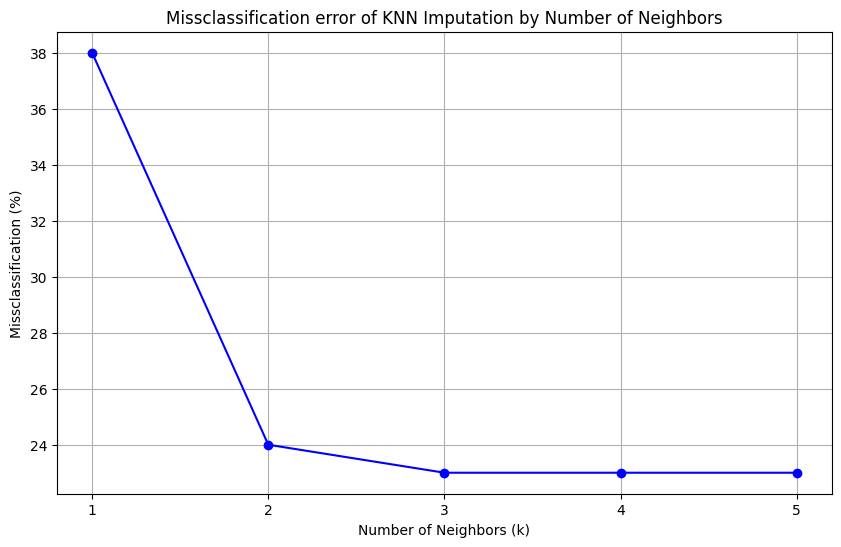

In [101]:
# Plot for missclassification error for KNN with increasing k
plt.figure(figsize=(10, 6))
plt.plot(k_array, miss_class*100, marker='o', linestyle='-', color='b')
plt.title('Missclassification error of KNN Imputation by Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Missclassification (%)')
plt.xticks(k_array)
plt.grid(True)
plt.show()

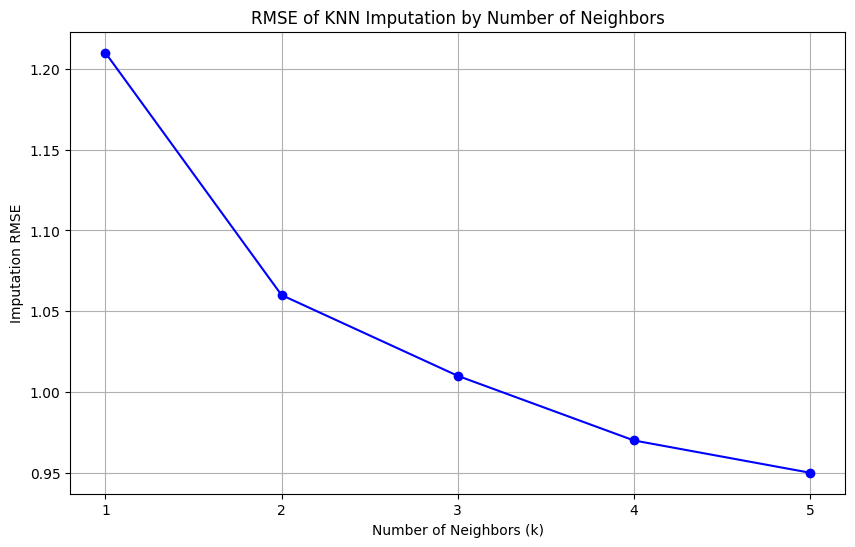

In [102]:
# Plot for rmse error for KNN with increasing k
plt.figure(figsize=(10, 6))
plt.plot(k_array, rmse, marker='o', linestyle='-', color='b')
plt.title('RMSE of KNN Imputation by Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Imputation RMSE')
plt.xticks(k_array)
plt.grid(True)
plt.show()

We chose to use $k=2$, as it is the obvious elbow for the missclassification error and to be consistent we use 2 for both as there is not a clear elbow for the RMSE error.

## Increase data missing

An investigation was conducted to analyse how the imputations methods compared when the proportion of data being removed was adjusted. Here we make a function to train each of the three imputers with a certain fraction of the data removed, and return the rmse and missclassification error for each imputer.

In [103]:
def train_imputers(train, frac_remove):
    # set the seed
    np.random.seed(5059)
    
    # Give value of 1 with 90% for each value in dataframe - 0s are then removed
    keep = np.random.binomial(n=1, p=(1-frac_remove), size=train.shape)
    train_w_na = train.mask(keep == 0)

    imputed_df_KNN = KNN(train_w_na, k=2)
    imputed_data_mf = missforest(train_w_na)
    imputed_data_mice = mice_r(train_w_na)

    df = pd.DataFrame(columns=['RMSE', 'Missclassification'])
    
    # Add vectors as rows
    df.loc[0] = rmse_classification_error(train_w_na, imputed_df_KNN, x_train)
    df.loc[1] = rmse_classification_error(train_w_na, imputed_data_mf, x_train)
    df.loc[2] = rmse_classification_error(train_w_na, imputed_data_mice, x_train)

    df['imputer'] = ['KNN','missForest', 'mice']
    
    return(df)

#### Train the imputers on different proportions of missing data

Now we train each of the imputers on 0.1, 0.15, 0.2, 0.25, and 0.3 proportion of missing data, and print the results as a table.

In [104]:
frac_removes = [0.1, 0.15, 0.2, 0.25, 0.3]

# Create an empty DataFrame to store results
results_df = pd.DataFrame()

# Apply the function to each frac_remove value and combine the results
for frac_remove in frac_removes:
    result = train_imputers(x_train, frac_remove)
    result['frac_remove'] = frac_remove  # Add a column for frac_remove value
    results_df = pd.concat([results_df, result], ignore_index=True)

print(results_df)

    RSME  Missclassification     imputer  frac_remove
0   0.24                1.06         KNN         0.10
1   0.15                0.89  missForest         0.10
2   0.23                1.27        mice         0.10
3   0.24                1.08         KNN         0.15
4   0.17                0.92  missForest         0.15
5   0.23                1.27        mice         0.15
6   0.24                1.09         KNN         0.20
7   0.19                0.96  missForest         0.20
8   0.24                1.28        mice         0.20
9   0.24                1.13         KNN         0.25
10  0.20                1.00  missForest         0.25
11  0.24                1.28        mice         0.25
12  0.25                1.14         KNN         0.30
13  0.24                1.07  missForest         0.30
14  0.23                1.29        mice         0.30


#### Make plots of the results

The table is slightly hard to interpret, so we made plots of the rmse and missclassification error changes with proportion of data removed coloured by the imputation method. 

The RMSE Plot:

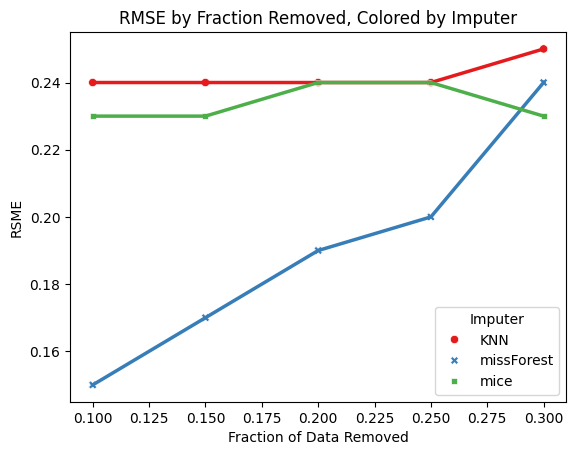

In [110]:
# one plot for rsme coloured by imputer with increasing frac
sns.scatterplot(x='frac_remove', y='RMSE', hue='imputer', data=results_df, style='imputer', markers=True, palette='Set1')
sns.lineplot(x='frac_remove', y='RMSE', hue='imputer', data=results_df, palette='Set1', legend=False, linewidth=2.5)
plt.title('RMSE by Fraction Removed, Colored by Imputer')
plt.xlabel('Fraction of Data Removed')
plt.ylabel('RSME')
plt.legend(title='Imputer')
plt.show()

The missclassification plot:

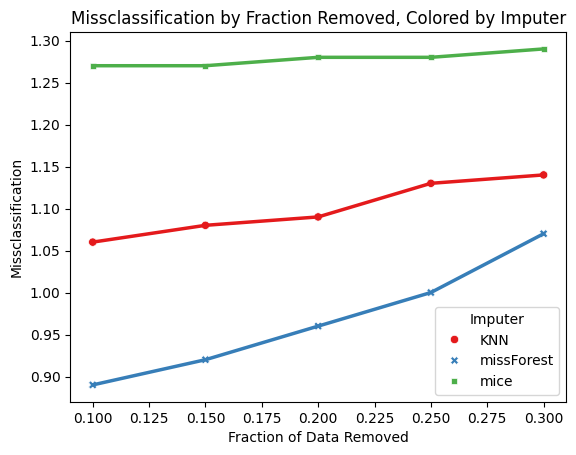

In [111]:
# one plot for missclassification coloured by imputer with increasing frac
sns.scatterplot(x='frac_remove', y='Missclassification', hue='imputer', data=results_df, style='imputer', markers=True, palette='Set1')
sns.lineplot(x='frac_remove', y='Missclassification', hue='imputer', data=results_df, palette='Set1', legend=False, linewidth=2.5)
plt.title('Missclassification by Fraction Removed, Colored by Imputer')
plt.xlabel('Fraction of Data Removed')
plt.ylabel('Missclassification')
plt.legend(title='Imputer')
plt.show()

From this missforest is generally the best for both rmse and missclassification error, but gets dramatically worse for numeric data at around 30% of the data being removed, at which mice performs slightly better. KNN seems to be the second best; the categorical version using the hamming distance is much better than mice's categorical imputer (polytomous logistic regression). However the KNN on the numeric data performs about the same as mice's numeric imputer ( predictive mean matching).

## Full pipeline

The next section of this notebook uses the methods discussed of imputation and shows how the models produced using them compares to the orginal data. To do this the pipeline that was used in the model creation section of this project has been used here to prepare the data to be used for the models. *Note:* Remembering as mentioned previously that the data being inputted into this pipeline has not been standardised.

## Pipeline on imputed data frames:

This section shows how having removed approximately 10% of the data, the 3 imputations methods discussed have been employed to impute the missing data on the non-standardised data. Also the training labels have been re-attached to the data before it has been passed into the pipeline.

In [112]:
# read in the data
train = pd.read_csv("train.csv", index_col=False)

# Correct data types
# Columns that should be Categorical
train[columns_to_convert_cat] = train[['Drug','Sex', 'Ascites', 'Hepatomegaly', 'Spiders','Edema', 'Status']].astype('category')

# Columns that should be Integer
train[columns_to_convert_int] = train[['Cholesterol', 'Copper', 'Tryglicerides', 'Platelets','Stage']].astype('int64')

# drop response
y_train = train['Status']
x_train = train.drop(columns = "Status")

# now remove data
# set the seed
np.random.seed(5059)

# Give value of 1 with 90% for each value in dataframe - 0s are then removed
keep = np.random.binomial(n=1, p=0.9, size=x_train.shape)
train_w_na = x_train.mask(keep == 0)

In [113]:
# imputed data frames: 
imputed_df_KNN = KNN(train_w_na, k=2)
imputed_data_mf = missforest(train_w_na)
imputed_data_mice = mice_r(train_w_na)

In [114]:
# add the response back in
imputed_df_KNN_full = pd.concat([y_train, imputed_df_KNN], axis = 1)
imputed_data_mf_full = pd.concat([y_train, imputed_data_mf], axis = 1)
imputed_data_mice_full = pd.concat([y_train, imputed_data_mice], axis = 1)

In [115]:
# apply the full pipeline to each data set
true_cleaned = full_pipeline(train) # without any imputations
KNN_cleaned = full_pipeline(imputed_df_KNN_full)
mf_cleaned = full_pipeline(imputed_data_mf_full)
mice_cleaned = full_pipeline(imputed_data_mice_full)

Having processed the 3 imputed datasets as well as the orginal dataset as a benchmark, below we fit the best model that was selected in the model selection phase of this project. Using the hyper-parameters that were found using a grid-search method.

In [116]:
from sklearn.metrics import log_loss
# Define a function to prepare the data and fit the model
def log_loss_model(data):
    # Labels
    labels = data['remainder__Status'].copy()
    # Get dataframe in the format for the final model
    data_set = data.drop(['remainder__Status', 'remainder__id'], axis=1)
    # Final model
    params = {'alpha': 0, 'colsample_bytree': 0.3, 'lambda': 1, 'max_depth': 9, 'subsample': 0.5, 'n_estimators': 1000, 'eta': 0.01, 'eval_metric': 'mlogloss',
              'random_state': 5059}
    xgb_classifier = xgb.XGBClassifier(objective = 'multi:softprob', **params)

    cv_results = cross_val_score(xgb_classifier, data_set, labels, cv=5, scoring = 'neg_log_loss')

    avg_loss = np.mean(-cv_results)

    return(avg_loss)

# Prepare and fit the model for each dataset
data = [KNN_cleaned, mf_cleaned, mice_cleaned, true_cleaned]
names = ["KNN", "missforest", "MICE", "Actual data"]

# Calculate log loss for each model
for dataset, name in zip(data, names):
    loss = log_loss_model(dataset)
    print(f"Average Log loss for {name}: {round(loss, 3)}")

Average Log loss for KNN: 0.453
Average Log loss for missforest: 0.449
Average Log loss for MICE: 0.457
Average Log loss for Actual data: 0.435


Having fit these models we wanted the *logloss* metric as described in the project outline to compare how each of the different dataframes impact the results. We obtained the average logloss for each of the three imputation methods and the actual data using 5 fold cross-validation. The smaller the logloss the better; the smallest is our actual data at 0.435, then missforest at 0.449, then KNN at 0.453 and finally MICE at 0.457. These are clearly all good imputation methods producing similar results to the actual data. Furthermore, these logloss values agrees with our previous rankings of imputation methods (missforest, KNN, then mice) using the rmse and missclassification error. 